# Optimizing diversified investment portfolios considering cryptocurrencies and other Brazilian financial products, using Markowitz model approach, GARCH models and Genetic algorithms.

*** By Pablo Calvache***

In [1]:
#Imports

from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import certifi
import urllib3
import pycurl
import datetime, time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

from datetime import datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline

# Data extraction

Using Python curl and HTML libraries, data from websites containing closing prices of either stocks and cryptocurrencies assets, is extracted and summarized. Such data is public!

** OBS: ** Regardless the Brazilian stocks prices are given in *BRL (Real)* and the crypto prices are given in *USD (American Dolar)*,  transforming from USD to BRL is desnecessary due only differentiated series are considered by Markowitz models. 

## Stock info

Data at this stage, is obtained from Yahoo finance portal because of its HTML structure and easiness at reading.  

In [2]:
# https://br.financas.yahoo.com/quote/PETR4.SA/history?period1=1452045600&period2=1515549600&interval=1d&filter=history&frequency=1d
def date_to_seconds(date_string, formatting = '%d-%m-%Y' ):
    t = datetime.strptime(date_string, formatting)
    return int(time.mktime(t.timetuple()))

def get_historical_data(name, init, end):
    data_close_prices, index_date = [], []
    url = "https://br.finance.yahoo.com/quote/{name}/history?period1={init}&period2={end}&interval=1d&filter=history&frequency=1d"\
                .format(name=name, init=str(init), end=str(end))
    print('Downloading from ... '+ url)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    r = http.request('GET', url)
    rows = BeautifulSoup(r.data, 'html.parser').findAll('table')[1].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        #data.append({'date': divs[0].text, 
                    #'open': divs[1].text,
                    #'max': divs[2].text,
                    #'min': divs[3].text,
                    #'close': divs[4].text})
                    
        if len(divs) < 4:
            continue
            
        data_close_prices.append(float(divs[4].text.replace(",", ".")))
        index_date.append(divs[0].text)
    
    key = 'stock_close_'+name.split('.')[0]
    return pd.DataFrame({key:list(reversed(data_close_prices))}, index = list(reversed(index_date)))

def download_portafolio_as_pandas(papers, interval):
    portafolio_pd = pd.DataFrame()
    for paper in papers:
        init_sec = date_to_seconds(interval['init'])
        end_sec = date_to_seconds(interval['end'])
        if portafolio_pd.size == 0:
            portafolio_pd = get_historical_data(paper, init_sec, end_sec)
        else:
            portafolio_pd = portafolio_pd.join(get_historical_data(paper, init_sec, end_sec), how ='left')
    
    return portafolio_pd

In [49]:
# downloading data

papers = ["ABEV3.SA", "ITUB4.SA", "BBDC3.SA", "PETR4.SA", "VALE3.SA", "BSAN33.SA", "ITSA4.SA", 
          "VIVT4.SA", "BBSE3.SA", "CIEL3.SA"]

#"BRSR6.SA","ELET6.SA","CESP6.SA","PCAR4.SA",
#          "CGAS5.SA","CMIG4.SA","CPLE6.SA","ELPL4.SA",

# Yahoo allows to download 100 days only, therefore
time_intervals = [{'init' : '01-07-2018', 'end' : '31-08-2018'},
                  {'init' : '01-04-2018', 'end' : '30-06-2018'},
                  {'init' : '01-01-2018', 'end' : '31-03-2018'},
                  {'init' : '01-10-2017', 'end' : '31-12-2017'},
                  {'init' : '01-07-2017', 'end' : '30-09-2017'},
                  {'init' : '01-04-2017', 'end' : '30-06-2017'},
                  {'init' : '01-01-2017', 'end' : '31-03-2017'}]


stock_prices_pd = pd.DataFrame()
for time_interval in time_intervals:
    if stock_prices_pd.size == 0:
        stock_prices_pd = download_portafolio_as_pandas(papers, time_interval)
    else:
        stock_prices_pd = pd.concat([download_portafolio_as_pandas(papers, time_interval), stock_prices_pd])

#### Formatting Date index

In [50]:
def formating_yahoo_date(date_text):
    date_text = date_text.replace(' de ', '-')
    splitted_date = date_text.split('-')
    day, month_pt, year = splitted_date[0], splitted_date[1], splitted_date[2]
    return {
      'dez': lambda year, day: year + '-' + '12' + '-' + day,
      'nov': lambda year, day: year + '-' + '11' + '-' + day,
      'out': lambda year, day: year + '-' + '10' + '-' + day,
      'set': lambda year, day: year + '-' + '09' + '-' + day,
      'ago': lambda year, day: year + '-' + '08' + '-' + day,
      'jul': lambda year, day: year + '-' + '07' + '-' + day,
      'jun': lambda year, day: year + '-' + '06' + '-' + day,
      'mai': lambda year, day: year + '-' + '05' + '-' + day,
      'abr': lambda year, day: year + '-' + '04' + '-' + day,
      'mar': lambda year, day: year + '-' + '03' + '-' + day,
      'fev': lambda year, day: year + '-' + '02' + '-' + day,
      'jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

stock_prices_pd.index = [formating_yahoo_date(date_yahoo) for date_yahoo in stock_prices_pd.index.values]

In [51]:
stock_prices_pd.tail()

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
2018-08-06,19.30,46.46,28.40,21.04,52.40,19.01,10.87,42.28,25.00,13.83
2018-08-07,19.17,46.18,27.78,20.71,52.75,19.50,10.85,41.52,24.70,13.28
2018-08-08,19.16,45.10,27.27,20.14,52.40,19.55,10.62,40.95,24.64,14.00
2018-08-09,19.27,44.86,26.83,20.34,51.84,19.60,10.41,40.83,24.52,14.50
2018-08-10,18.91,43.23,25.43,19.59,51.71,19.60,10.01,40.47,23.10,14.12


## Croptocurrencies

#### Loading Objects from coinMarket

Due criptocurrencies are harder to trade and exchange, an important criterion in ordet to select the correct ones is the ease in exhancging... 

In [52]:
#date format = 20170817
def formating_coinmarket_date(date_text):
    date_text = date_text.replace(',', '')
    splitted_date = date_text.split(' ')
    day, month_pt, year = splitted_date[1], splitted_date[0], splitted_date[2]
    return {
      'Dec': lambda year, day: year + '-' + '12' + '-' + day,
      'Nov': lambda year, day: year + '-' + '11' + '-' + day,
      'Oct': lambda year, day: year + '-' + '10' + '-' + day,
      'Sep': lambda year, day: year + '-' + '09' + '-' + day,
      'Aug': lambda year, day: year + '-' + '08' + '-' + day,
      'Jul': lambda year, day: year + '-' + '07' + '-' + day,
      'Jun': lambda year, day: year + '-' + '06' + '-' + day,
      'May': lambda year, day: year + '-' + '05' + '-' + day,
      'Apr': lambda year, day: year + '-' + '04' + '-' + day,
      'Mar': lambda year, day: year + '-' + '03' + '-' + day,
      'Feb': lambda year, day: year + '-' + '02' + '-' + day,
      'Jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

def get_values_table(source_path, currency, start_date, end_date):
    url = source_path.format(currency = currency, start_date = start_date, end_date = end_date)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    print('Downloading from ... '+ url)
    r = http.request('GET', url)
    #r = urllib.urlopen(url).read() # Python 2
    soup = BeautifulSoup(r.data, 'html.parser')
    table = soup.find('table')
    data = []
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    
    df_temp = pd.DataFrame.from_records(list(reversed(data)))
    df_temp.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
   
    close_prices = [float(close) for close in list(df_temp['Close'])]
    df_close = pd.DataFrame({'ccurr_'+currency+'_close' : close_prices}, index = df_temp['Date'])
    
    return df_close

def download_cripto_currencies_close_price_as_pandas(currencies, date_interval):
    source_path = 'https://coinmarketcap.com/currencies/{currency}/historical-data/?start={start_date}&end={end_date}'
    ccurrencies_pd = pd.DataFrame()
    for key, val in currencies.items():
        if ccurrencies_pd.size == 0:
            ccurrencies_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
        else:
            temp_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
            ccurrencies_pd = ccurrencies_pd.join(temp_pd, how ='left')
    
    return ccurrencies_pd

def from_usd_to_pt(currencies_pd, exchange_pd):
    currencies_pd_temp = currencies_pd.join(exchange_pd, how='inner')
    return cripto_currencies_pd.transform(lambda x: x * currencies_pd_temp['close_price_usd_pt'])

In [53]:
currencies = {'bitcoin' : 'bitcoin', 
              'ethereum' : 'ethereum', 
              'bitcoin_cash' : 'bitcoin-cash', 
              'litecoin' : 'litecoin',
              'ripple' : 'ripple',
              'NEO' : 'neo',
              'stellar': 'stellar',
              'monero' : 'monero',
              'EOS' : 'eos',
              'dash' : 'dash'}

# 'IOTA' : 'iota',

date_interval = {'init': '2017-01-01', 'end' : '2018-07-31' }

cripto_currencies_pd = download_cripto_currencies_close_price_as_pandas(currencies, date_interval)
cripto_currencies_pd.index =[formating_coinmarket_date(date_coinm) for date_coinm in cripto_currencies_pd.index.values]
#cripto_currencies_pd = from_usd_to_pt(cripto_currencies_pd, usd_br_pd)

In [54]:
# trabajar con coingecko - op 1
# 
cripto_currencies_pd

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
2017-01-01,998.33,8.17,NaN,4.51,0.006368,0.141841,0.002481,13.97,NaN,11.23
2017-01-02,1021.75,8.38,NaN,4.65,0.006311,0.145642,0.002477,16.05,NaN,11.81
2017-01-03,1043.84,9.73,NaN,4.63,0.006386,0.140422,0.002554,16.09,NaN,12.78
2017-01-04,1154.73,11.25,NaN,4.84,0.006570,0.136734,0.002735,18.53,NaN,16.52
2017-01-05,1013.38,10.25,NaN,4.29,0.006201,0.131070,0.002598,16.19,NaN,14.38
2017-01-06,902.20,10.25,NaN,3.86,0.006315,0.135472,0.002494,14.03,NaN,12.03
2017-01-07,908.59,9.87,NaN,3.96,0.006366,0.131104,0.002396,13.06,NaN,12.44
2017-01-08,911.20,10.29,NaN,3.99,0.006233,0.132609,0.002355,13.47,NaN,12.54
2017-01-09,902.83,10.33,NaN,4.30,0.006167,0.123767,0.002347,13.74,NaN,12.09
2017-01-10,907.68,10.55,NaN,4.59,0.006698,0.133864,0.002355,13.39,NaN,12.49


## Preprocessing, financial time series theory

In order to avoid biases caused by sporious correlations and not stationary trends a and variance, the original 'closing price' series of each asset, a derivation and logaritmic scale transformation is performed in order to make the series stationary in trend and variance. Such method delivers the data in a format compatible with the Markowitz model input, and such transformations also are kind of standar in finance analyisis.

In [55]:
# Rt - returns
def get_returns_in_percent(pd_dataframee):
    return (pd_dataframee.diff() / pd_dataframee.shift(periods=1))

# rt - rate returns
def get_rate_return(pd_dataframe):
    pd_temp = np.log(pd_dataframe)
    return pd_temp.diff()

** Non stationary Time Series **

In [ ]:
cripto_currencies_pd['ccurr_bitcoin_close'].plot()

** *Diff* or First order Derived Series: Making the series stationary in trend**

In [ ]:
get_returns_in_percent(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

**Most of the time series models works with $r_t$ (spin term??) rather than $R_t$. So by applying the $r_t$ function defined above, we obtain:**

In [12]:
get_returns_in_percent(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_tether_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023459,0.025704,NaN,0.031042,-0.008951,0.026798,-0.001612,0.14889,NaN,0.0,0.051647


In [13]:
get_rate_return(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_tether_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023188,0.025379,NaN,0.03057,-0.008991,0.026445,-0.001614,0.138797,NaN,0.0,0.050358


**OBS:** Despite the similarity in the plots above, returns and return rates are sighlty different from each other. 

** Checking the time series distribution, we get a normal distribution **

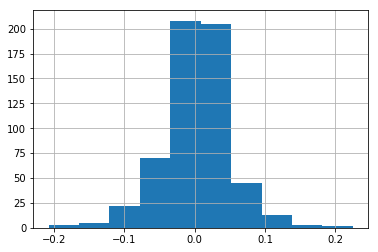

In [14]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].hist()

### Merging Data and filling NaN values

NaN values are in the dataframe due several assets (some cryptocurrencies mainly) have not got a long track closing price history. Such as the case with Cardano and Bit Coin Cash, the first one mentioned for instance has history starting from 13-10-2017 only, hence it is assumed there was not any variance in closing prices difference percent (already differentiated series) before that point filling such missing values with 0. This applies also for None values along the data.

In [57]:
# Stocks percent returns
percent_stocks_returns = get_returns_in_percent(stock_prices_pd)
# remmoving duplicated indexes
percent_stocks_returns = percent_stocks_returns[~percent_stocks_returns.index.duplicated(keep='first')]
percent_stocks_returns = percent_stocks_returns.fillna(0)
stock_return_rates = get_rate_return(stock_prices_pd)
stock_return_rates = stock_return_rates.fillna(0)

# Criptocurrencies percent returns
percent_cripto_returns = get_rate_return(cripto_currencies_pd)
# remmoving duplicated indexes
percent_cripto_returns = percent_cripto_returns[~percent_cripto_returns.index.duplicated(keep='first')]
percent_cripto_returns = percent_cripto_returns.fillna(0)
ccurr_return_rates = get_rate_return(cripto_currencies_pd)
ccurr_return_rates = ccurr_return_rates.fillna(0)

# Merged DF
portafolio_pd = stock_prices_pd.join(cripto_currencies_pd, how = 'inner')
percent_returns_pd = get_rate_return(portafolio_pd)
# remmoving duplicated indexes
percent_returns_pd = percent_returns_pd[~percent_returns_pd.index.duplicated(keep='first')]
percent_returns_pd = percent_returns_pd.fillna(0)
return_rates_pd = get_rate_return(portafolio_pd)
return_rates_pd = return_rates_pd.fillna(0)

### Augmented Dickey fueller test

In [58]:
from statsmodels.tsa.stattools import adfuller

dickey_outcome = return_rates_pd.apply(lambda col: adfuller(col)[0])
dickey_outcome

stock_close_ABEV3          -19.724147
stock_close_ITUB4          -21.201347
stock_close_BBDC3          -21.535764
stock_close_PETR4           -5.116427
stock_close_VALE3          -14.770932
stock_close_BSAN33         -12.610439
stock_close_ITSA4          -13.163923
stock_close_VIVT4          -16.885107
stock_close_BBSE3          -12.067777
stock_close_CIEL3          -14.215063
ccurr_bitcoin_close        -19.209836
ccurr_ethereum_close       -17.855852
ccurr_bitcoin-cash_close    -6.104374
ccurr_litecoin_close        -4.887639
ccurr_ripple_close         -10.840650
ccurr_neo_close            -20.950824
ccurr_stellar_close        -17.672046
ccurr_monero_close         -21.108018
ccurr_eos_close             -4.122156
ccurr_dash_close           -12.630605
dtype: float64

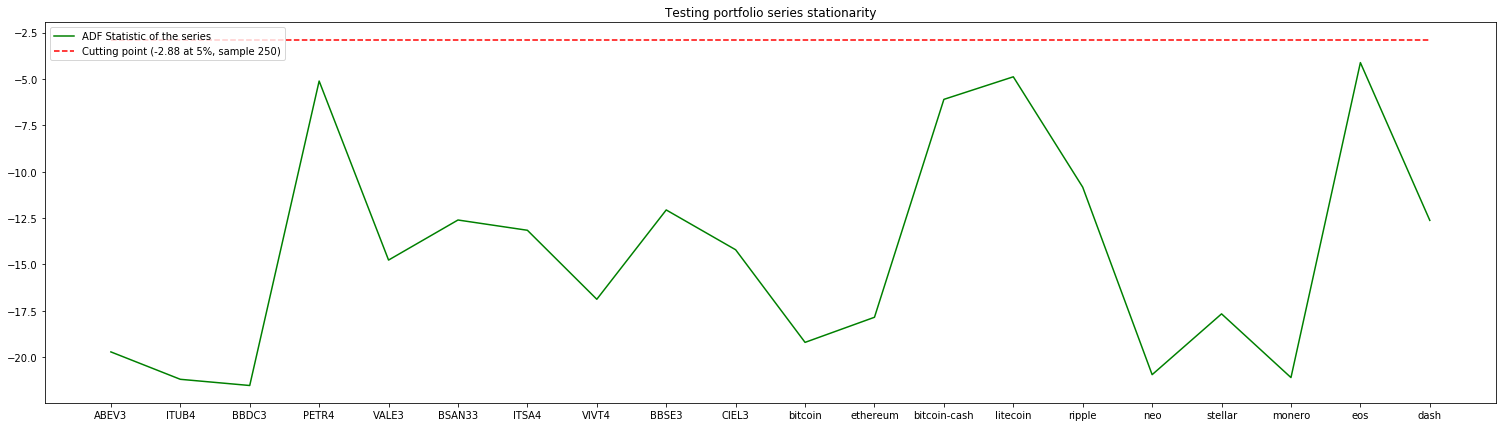

In [59]:
plt.figure(figsize=(26,7))
x_lab = [index.replace('stock','').replace('ccurr','').replace('close', '').replace('_','') for index in dickey_outcome.index]
plt.xticks(range(len(dickey_outcome.values)), x_lab) 
plt.plot(dickey_outcome.values,label='ADF Statistic of the series',color='green')
plt.plot(np.full((1, len(dickey_outcome.values)), -2.88)[0],'k--',label='Cutting point (-2.88 at 5%, sample 250)',color='red')
plt.title('Testing portfolio series stationarity')
plt.legend(loc='upper left')
plt.show()

# Descriptive analysis


**Negative correlation between sotck and cryptocurrencies markets**: 


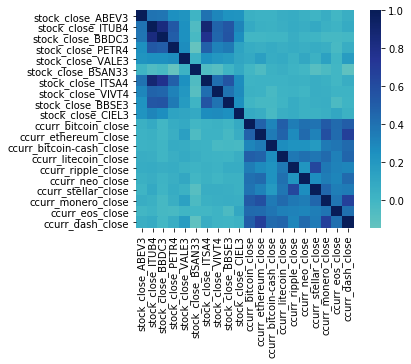

In [60]:
## Pearson correlation - All portafolio
sns.heatmap(percent_returns_pd.tail(360).corr(method='pearson'),  cmap="YlGnBu", center=0, square=True)

The behaviour described in the hypthotesis above, is showed in the data as well, menaning it works also for Brazilian stock assets.

## GARCH models - Getting return value of an asset by using 

**OBS: ** Whenever a GARCH Model does not converge, it is used the mean of the series instead considering the recomendations given by some literature regarding the subject, such as (dell course).
"when the data is to messy or may not be able to fit a medium/high complexity model, working with the expected value or mean turns out a better option".

In [61]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

from arch import arch_model

def fit_garch(TS, p_range = 3, o_range = 0, q_range = 3, dist = "StudentsT"):
    dict_temp = {}
    best_aic = None
    best_order = None
    best_model = None
    for p in range(p_range+1):
        for o in range(o_range+1):
            for q in range(q_range+1):
                try:
                    am = arch_model(TS, p=p, o=o, q=q, dist = 'StudentsT')
                    res = am.fit(update_freq=5, disp='off')
                    tmp_aic = res.aic

                    if best_aic is None:
                        best_aic = tmp_aic
                    if tmp_aic <= best_aic:
                        dict_temp = {'best_aic' : tmp_aic, 'model': am, 'results' : res.forecast().mean.iloc[-1]}
                except:
                    if 'best_aic' not in dict_temp:
                        dict_temp = {'best_aic' : 9999999, 'results' : TS.mean() }
                    continue
    return dict_temp


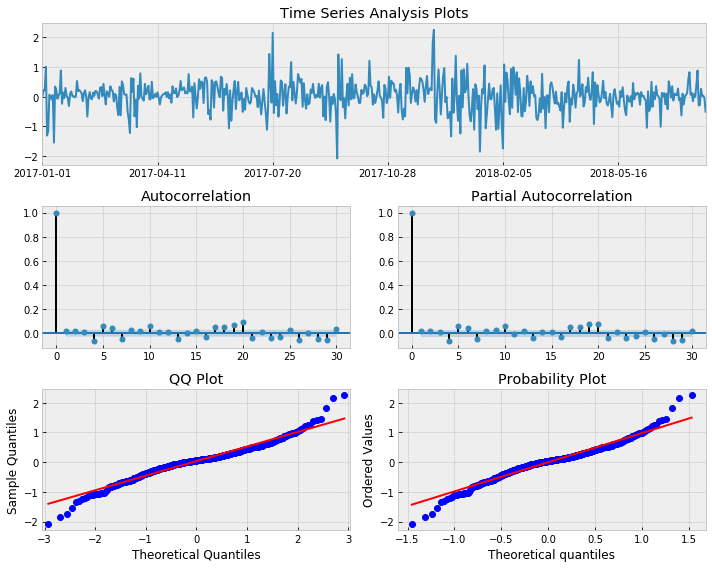

In [62]:
tsplot(np.multiply(ccurr_return_rates['ccurr_bitcoin_close'], 10), lags = 30)

In [63]:
am = arch_model(np.multiply(ccurr_return_rates['ccurr_bitcoin_close'], 10), mean='AR',p=7, o=0, q=7, dist = 'StudentsT')
res = am.fit(update_freq=5, disp='off')
res

                              AR - GARCH Model Results                              
Dep. Variable:          ccurr_bitcoin_close   R-squared:                      -0.003
Mean Model:                              AR   Adj. R-squared:                 -0.003
Vol Model:                            GARCH   Log-Likelihood:               -340.677
Distribution:      Standardized Student's t   AIC:                           715.355
Method:                  Maximum Likelihood   BIC:                           789.438
                                              No. Observations:                  577
Date:                      Sun, Aug 12 2018   Df Residuals:                      560
Time:                              17:49:48   Df Model:                           17
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Cons

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

                        Constant Mean - GARCH Model Results                         
Dep. Variable:          ccurr_bitcoin_close   R-squared:                      -0.003
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                            GARCH   Log-Likelihood:                983.541
Distribution:      Standardized Student's t   AIC:                          -1949.08
Method:                  Maximum Likelihood   BIC:                          -1909.86
                                              No. Observations:                  577
Date:                      Sun, Aug 12 2018   Df Residuals:                      568
Time:                              17:49:49   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

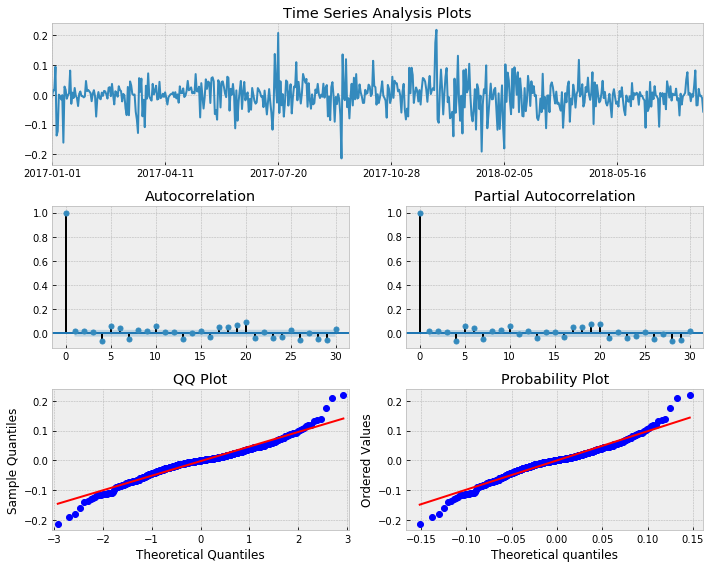

In [64]:
model_sample = fit_garch(ccurr_return_rates['ccurr_bitcoin_close'])
res = model_sample['model'].fit(update_freq=5, disp='off')
print(res)
tsplot(res.resid, lags = 30)


** Predicting the returns **

In [65]:
# Testing
test_returned = ccurr_return_rates[145: 175].apply(lambda col: fit_garch(col)['results'])
test_returned

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encou

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
h.1,0.004045,0.003822,0.0,0.006162,-0.010336,0.020073,0.001956,0.003072,0.0,0.014683


Considering expression: 

$$ R_t = {e^{r_t}} - 1 $$

In [66]:
# Slighlty different from the previous one, but different anyway
test_returned.apply(lambda col: (np.exp(col) - 1))

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
h.1,0.004054,0.003829,0.0,0.006181,-0.010283,0.020276,0.001957,0.003077,0.0,0.014791


# Limitations

As the criteria for analysing a good fitted model are ausually graplhical, automate a GARCH model the best way possible is difficult.

## Drawing Markowitz efficient frontier


### OBS:

When simulating with genetic algorithims, there is a possibility of some portafolios may not match pre-fixed risk value. Furthemore there is a chance than a portafolio with a very close risk of any of the pre-fixed ones, may have a higher return value.

In order to minimize the effect of such issues, the efficient Markowithz frontier is going to be composed by the portafolios with the maximum return within an interval of +- 0.1 per each risk pre-fixed risk point. 

In [67]:
def return_risk_interval(df, number_of_steps = 5): 
    max_return = df.loc[df['return'] == df['return'].max()]
    min_risk = df.loc[df['risk'] == df['risk'].min()]

    delta = (max_return.iloc[0]['risk'] - min_risk.iloc[0]['risk']) / float(number_of_steps)
    if delta == 0:
        delta = 0.00001
    steps = list()

    for i in list(range(0,number_of_steps + 1)):
        if i == 0:
            steps.append(min_risk.iloc[0]['risk'])
        else:
            steps.append(steps[i-1] + delta)

    return [tuple([i-(delta*0.45), i+(delta*0.45)]) for i in steps] # 0,45 * delta guaranties interval overlapping does not Occur  

def drawing_frontier(df):
    steps_risk_interval = return_risk_interval(df)
    frontier = pd.DataFrame()
    for interval in steps_risk_interval:
        sliced_df = df.loc[(df['risk'] > interval[0])&(df['risk'] < interval[1])]

        if len(sliced_df) == 0: # If this condition is True, means for such interval, does not exist a solution.
            continue
            
        max_return_in_interval = max(sliced_df['return'])
        optimal_interval_portafolio = df.loc[df['return'] == max_return_in_interval].iloc[[0]]
        frontier = pd.concat([frontier, optimal_interval_portafolio])
    
    return frontier

# Call to execute
#frontier = drawing_frontier(df_ga_stock_output)  
#sns.lmplot(x="risk", y="distribution_return", data=frontier, fit_reg=True)


### Ratio of sharpe methods

In [68]:
def get_free_risk_asset_return(annual_rate=0.4, investment_period_in_days=30):
    daily_rate = (1.0+annual_rate)**(1.0/360.0) - 1.0
    free_risk_asset_return = 1
    for i in range(0, investment_period_in_days):
        free_risk_asset_return = free_risk_asset_return + (free_risk_asset_return * daily_rate)
        
    return free_risk_asset_return - 1
    
    
# Ratio of sharpe
def get_ratio_of_sharpe(weights, input_df, free_risk_asset_return):
    
    returns_portafolio = input_df.mean().dot(weights)
    std_portafolio = input_df.cov().dot(weights).dot(weights) ** 0.5

    return (returns_portafolio - free_risk_asset_return) / std_portafolio

## Random simulations - Workflow Example

A random simulation sets random values to the weights according to a given ditribution, gaussian mainly.

In [33]:
# test
def get_train_test_data(pd_dataframe, train_data_size):
    df_size = len(pd_dataframe.index)
    return pd_dataframe[0:df_size*train_data_size], pd_dataframe[df_size*train_data_size, df_size]

# Objective function using means for calculating returns
def random_simulations(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_mean = return_df.mean() # Optimizes the process by calculating this just once
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_mean.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Objective function using GARCH for calculating returns
def random_simulations_using_garch(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_predict = return_rate_df.apply(lambda col: fit_garch(col)['results']) # Optimizes the process by calculating this just once
    returns_predict = returns_predict.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_predict.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Simulate portfolios method
def simulate_portafolios(function, lag = 0, window_time = 60, n = 1000):
    
    tail = len(percent_returns_pd.index)
    
    # Stocks only portafolio
    map_test = function(percent_stocks_returns[tail - (lag + window_time): tail - lag], 
                        stock_return_rates[tail - (lag + window_time): tail - lag],
                        n)
    print('stocks.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_stock_df = pd.DataFrame(map_test)
    simulations_stock_df['portafolio_type'] = ['stock_only' for i in simulations_stock_df.index]

    # Criptocurrencies only portafolio
    map_test = function(percent_cripto_returns[tail - (lag + window_time): tail - lag], 
                        ccurr_return_rates[tail - (lag + window_time): tail - lag], 
                        n)
    print('ccurr.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_ccur_df = pd.DataFrame(map_test)
    simulations_ccur_df['portafolio_type'] = ['ccurr_only' for i in simulations_ccur_df.index]

    # Total portafolio
    map_test = function(percent_returns_pd[tail - (lag + window_time): tail - lag],
                        return_rates_pd[tail - (lag + window_time): tail - lag],
                        n)
    print('mixed.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_df = pd.DataFrame(map_test)
    simulations_df['portafolio_type'] = ['mixed_assets' for i in simulations_df.index]
    
    return simulations_stock_df, simulations_ccur_df, simulations_df


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

stocks.. init: 370 end: 400


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


ccurr.. init: 370 end: 400


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


mixed.. init: 370 end: 400


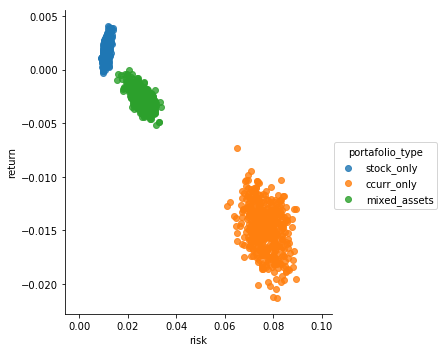

In [34]:
# Simulating Portfolios 
lag, window_time = 0, 30

# With mean
#simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations, lag, window_time,500)

# With Garch
simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations_using_garch, lag, window_time,500)

simulation_frames = [simulations_stock_df, simulations_ccur_df, simulations_df]
simulations_concatenated = pd.concat(simulation_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

*** Drawing Markowitz efficient frontier ***

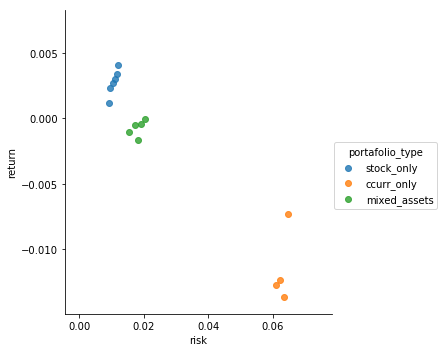

In [35]:
stock_frontier = drawing_frontier(simulations_stock_df)
ccur_frontier = drawing_frontier(simulations_ccur_df)
mixed_frontier = drawing_frontier(simulations_df)

summarized_frontiers = [stock_frontier, ccur_frontier, mixed_frontier]
summarized_frontiers = pd.concat(summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_frontiers, fit_reg=False)

In [36]:
stock_frontier

,assets,index,return,risk,weights,portafolio_type
420,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",420,0.001164,0.009171,"[0.191373815119, 0.0544083538341, 0.0038498467...",stock_only
93,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",93,0.002363,0.009642,"[0.0853283117115, 0.00418545236063, 0.01923721...",stock_only
47,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",47,0.002718,0.010372,"[0.135715024881, 0.0792090213042, 0.0868770949...",stock_only
162,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",162,0.003046,0.011031,"[0.123481688824, 0.10976370933, 0.124143613, 0...",stock_only
306,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",306,0.003417,0.011580,"[0.104794386753, 0.127706887992, 0.14466324133...",stock_only
427,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",427,0.004077,0.012007,"[0.0709693233878, 0.127379552151, 0.1147952958...",stock_only


*** Ratio of Sharpe ***

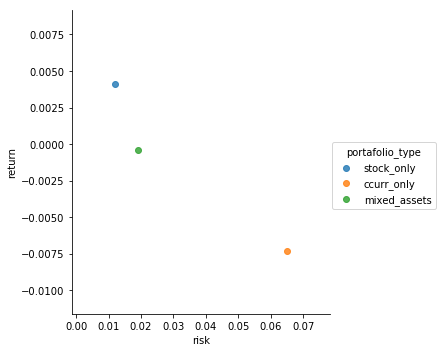

In [37]:
free_risk_asset = get_free_risk_asset_return(0.4, window_time)

# Calcuating ratio of sharpe of each asset belonging to the markwitz frontier

stock_frontier['ratio_of_sharpe'] = stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, free_risk_asset) , axis = 1)
ccur_frontier['ratio_of_sharpe'] = ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, free_risk_asset) , axis = 1)
mixed_frontier['ratio_of_sharpe'] = mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, free_risk_asset) , axis = 1)


# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = stock_frontier.loc[stock_frontier['ratio_of_sharpe'] == max(stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ccur_frontier.loc[ccur_frontier['ratio_of_sharpe'] == max(ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  mixed_frontier.loc[mixed_frontier['ratio_of_sharpe'] == max(mixed_frontier['ratio_of_sharpe'])]

# Ploting
summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

# Genetic Algorithms

***OBS: *** Few data with a linear Opt. Function (substraction) tend to fall in local "maximus" (higher probabiity of exploit). Whereas a non-linear F.O. apparently does not.

### GA functions declaration

In [69]:
'''
@article{DEAP_JMLR2012, 
    author    = " F\'elix-Antoine Fortin and Fran\c{c}ois-Michel {De Rainville} and Marc-Andr\'e Gardner and Marc Parizeau and Christian Gagn\'e ",
    title     = { {DEAP}: Evolutionary Algorithms Made Easy },
    pages    = { 2171--2175 },
    volume    = { 13 },
    month     = { jul },
    year      = { 2012 },
    journal   = { Journal of Machine Learning Research }
'''

############### GA Implementation #############

def run_ga(percent_returns_pd, rate_returns_pd, use_garch = False):
    
    from deap import creator, base, tools, algorithms
    
    #Selecting which method should be used for calculating the returns by asset 
    if use_garch is False:
        returns = percent_returns_pd.mean()
        returns_cov = percent_returns_pd.cov()
    else:
        returns = rate_returns_pd.apply(lambda col: fit_garch(col)['results'])
        returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
        returns_cov = percent_returns_pd.cov()
    
    # Objective function
    def objective_function(individual):
        if sum(individual) == 0:
            total = 1e-3
        else:
            total = sum(individual)
        w = np.divide(individual, total)
        return_portafolio = returns.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        if std_portafolio == 0:
            std_portafolio = 1e-4
        return (return_portafolio - std_portafolio,) 
    
    # Test minimuzing risk only
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    num_assets = len(percent_returns_pd.columns)
    toolbox = base.Toolbox()
    toolbox.register("attr_flt", random.uniform, 0.001, 0.999)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_flt, n=num_assets)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", objective_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=500)
    hof = tools.HallOfFame(1)
    
    # Run GA
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                       stats=stats, halloffame=hof, verbose=True)
    
    top10 = tools.selBest(population, k=10)
    return pop, returns, returns_cov


############ Outputs processing ##############


def get_portafolio_stats_using_garch(predicted_ret_garch, predicted_ret_garch_cov, optimal_percentuals):    
    return_in_percent = predicted_ret_garch.dot(optimal_percentuals)
    risk_in_percent = predicted_ret_garch_cov.dot(optimal_percentuals).dot(optimal_percentuals) ** 0.5
    return return_in_percent, risk_in_percent, optimal_percentuals

## GA optimization - Workflow Example

***OBS:*** Experiments regarding the optimal number of assets are out of the scope of this work. Such number is defined by the premises adopted since the beginning. 
Considering the most signifcant companies/criptocurrencies according of its size. Companies with a minimum of 80% percent of summarized market capital.


In [70]:
def execute_by_interval(lag = 0, window_time = 30, is_garch = False):    
    
    tail = len(percent_returns_pd.index)
    print('##DF LAG####', tail - (lag + window_time), tail - lag)
    # Stock only
    pop_stock, returns_stock, returns_cov_stock = run_ga(percent_stocks_returns[tail - (lag + window_time): tail - lag],
                                                           stock_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_stock:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats_using_garch(returns_stock,
                                                      returns_cov_stock, 
                                                      pop))
    df_ga_stock_output = pd.DataFrame.from_records(stats) 
    df_ga_stock_output.columns = ['return', 'risk', 'weights']
    df_ga_stock_output['portafolio_type'] = ['stock_only' for i in df_ga_stock_output.index]

    # Cripto Currencies only
    pop_ccurr, returns_ccurr, returns_cov_ccurr = run_ga(percent_cripto_returns[tail - (lag + window_time): tail - lag],
                                                           ccurr_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_ccurr:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats_using_garch(returns_ccurr,
                                                      returns_cov_ccurr,
                                                      pop))
    df_ga_ccur_output = pd.DataFrame.from_records(stats) 
    df_ga_ccur_output.columns = ['return', 'risk', 'weights']
    df_ga_ccur_output['portafolio_type'] = ['ccurr_only' for i in df_ga_ccur_output.index]
    
    # mixed 
    pop, returns_mix, returns_cov_mix = run_ga(percent_returns_pd[tail - (lag + window_time): tail - lag],
                                   return_rates_pd[tail - (lag + window_time): tail - lag],
                                   is_garch)
    print('#### mix returns ###' , returns_mix)
    stats = []
    for individual in pop:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats_using_garch(returns_mix,
                                                      returns_cov_mix,
                                                      pop))
    df_ga_output = pd.DataFrame.from_records(stats) 
    df_ga_output.columns = ['return', 'risk', 'weights']
    df_ga_output['portafolio_type'] = ['mixed_assets' for i in df_ga_output.index]
    
    return df_ga_stock_output.dropna(), df_ga_ccur_output.dropna(), df_ga_output.dropna()

In [71]:
# Exectuing optimization using means with returns

# Using mean for returns    
#df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, False)

# Using Garch for returns
df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(30,30, True)

##DF LAG#### 340 370


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0190202	0.00217389	-0.0273861	-0.0141605
1  	282   	-0.017569 	0.00179254	-0.0267268	-0.0139399
2  	317   	-0.0165081	0.00162007	-0.0278619	-0.0135167
3  	292   	-0.0156677	0.00148   	-0.0281757	-0.0134948
4  	289   	-0.0152056	0.00176539	-0.0276593	-0.0132474
5  	294   	-0.0147803	0.00198932	-0.0339987	-0.0128855
6  	296   	-0.0144089	0.00176099	-0.0268679	-0.012674 
7  	292   	-0.0141958	0.00197621	-0.0294639	-0.0123992
8  	294   	-0.014095 	0.00242401	-0.0305292	-0.0001   
9  	325   	-0.0138227	0.00268352	-0.0373404	-0.0001   
10 	332   	-0.0137471	0.00302009	-0.0416766	-0.0001   
11 	298   	-0.0139879	0.0044722 	-0.0706204	-0.0001   
12 	296   	-0.0133256	0.00367297	-0.0362506	-0.0001   
13 	300   	-0.0133675	0.00522757	-0.0706204	-0.0001   
14 	305   	-0.0127435	0.00439961	-0.0344164	-0.0001   
15 	326   	-0.0129081	0.00539486	-0.0501856	-0.0001   
16 	289   	-0.0132425	0.00739826	-0.0706204	-0.0001   
17 	297   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or ren

gen	nevals	avg      	std       	min       	max       
0  	500   	-0.061644	0.00374721	-0.0733926	-0.0532773
1  	291   	-0.0589812	0.00368133	-0.076139 	-0.0511428
2  	306   	-0.0570063	0.00417258	-0.0872613	-0.0479813
3  	289   	-0.0554175	0.00388385	-0.0797376	-0.0465467
4  	294   	-0.0542304	0.00462096	-0.0892264	-0.0465467
5  	326   	-0.0533042	0.00542595	-0.0991183	-0.0465467
6  	295   	-0.0523891	0.00686974	-0.147169 	-0.046132 
7  	306   	-0.0511668	0.00579629	-0.106127 	-0.0459993
8  	307   	-0.0509392	0.00662283	-0.0901742	-0.0459993
9  	297   	-0.0495385	0.00597117	-0.0832148	-0.0457376
10 	309   	-0.0496501	0.00710612	-0.0989813	-0.0457222
11 	313   	-0.049205 	0.0071615 	-0.112374 	-0.0456689
12 	297   	-0.0491317	0.00665042	-0.0875064	-0.0456689
13 	298   	-0.0488936	0.00658801	-0.097761 	-0.0456689
14 	254   	-0.0485171	0.00768478	-0.146476 	-0.0456689
15 	280   	-0.0489937	0.00860832	-0.146476 	-0.0456583
16 	278   	-0.0492432	0.00867009	-0.146476 	-0.0456583
17 	286   	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0424952	0.00380659	-0.0534242	-0.0308797
1  	316   	-0.0394971	0.00374692	-0.0592499	-0.0272684
2  	273   	-0.0367031	0.0036879 	-0.0538536	-0.025666 
3  	300   	-0.0341018	0.00414541	-0.0512096	-0.0185484
4  	294   	-0.0315064	0.00440014	-0.0530827	-0.0185484
5  	312   	-0.0296028	0.00540061	-0.0581227	-0.0185484
6  	287   	-0.0274272	0.00540382	-0.0555225	-0.0181014
7  	306   	-0.0262102	0.00613499	-0.0558838	-0.0181014
8  	277   	-0.0248672	0.0062745 	-0.0580785	-0.0155958
9  	284   	-0.0236848	0.00649426	-0.0525908	-0.0150248
10 	311   	-0.0237247	0.00820185	-0.0581757	-0.0150248
11 	258   	-0.0213223	0.00641849	-0.0525898	-0.0145447
12 	313   	-0.0221099	0.00862253	-0.0569905	-0.0144593
13 	305   	-0.0214754	0.00862716	-0.0620922	-0.0144593
14 	287   	-0.0199401	0.00790969	-0.0531421	-0.0141606
15 	281   	-0.0202851	0.00956062	-0.0617482	-0.0138032
16 	291   	-0.0196713	0.00958173	-0.0592084	-0.0138032
17 	303   

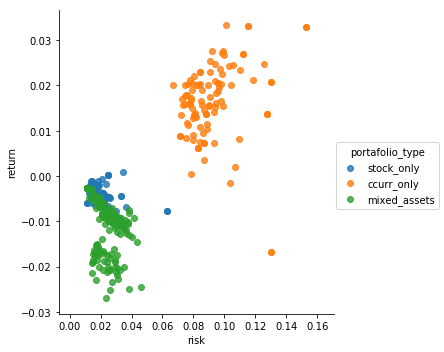

In [72]:
simulation_ga_frames = [df_ga_stock_output, df_ga_ccur_output, df_ga_output]
simulations_ga_concatenated = pd.concat(simulation_ga_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_ga_concatenated, fit_reg=False)

In [75]:
ga_stock_frontier = drawing_frontier(df_ga_stock_output)
ga_ccur_frontier = drawing_frontier(df_ga_ccur_output)
ga_mixed_frontier = drawing_frontier(df_ga_output)

pre_fixed_time_window = 5
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = ga_stock_frontier.loc[ga_stock_frontier['ratio_of_sharpe'] == max(ga_stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ga_ccur_frontier.loc[ga_ccur_frontier['ratio_of_sharpe'] == max(ga_ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  ga_mixed_frontier.loc[ga_mixed_frontier['ratio_of_sharpe'] == max(ga_mixed_frontier['ratio_of_sharpe'])]


ga_summarized_frontiers = [ga_stock_frontier, ga_ccur_frontier, ga_mixed_frontier]
ga_summarized_frontiers = pd.concat(ga_summarized_frontiers)

summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

In [ ]:
######

In [40]:
w = df_ga_output[df_ga_output['return'] == df_ga_output['return'].max()]['weights'][0]
# izzz modelo esta pifiando

In [41]:
tail = len(return_rates_pd['ccurr_bitcoin_close'])
return_rates_pd[340:370]

returns = return_rates_pd[340:370].apply(lambda col: fit_garch(col)['results'])
returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
returns_cov = return_rates_pd[340:370].cov()

return_portafolio = returns.dot(w)
std_portafolio = returns_cov.dot(w).dot(w) ** 0.5

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

In [42]:
print(return_portafolio)

17.0022257389


In [ ]:
#####

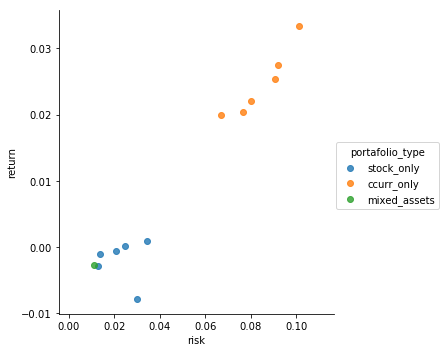

In [76]:
sns.lmplot(x="risk", y="return",hue="portafolio_type", data=ga_summarized_frontiers, fit_reg=False)

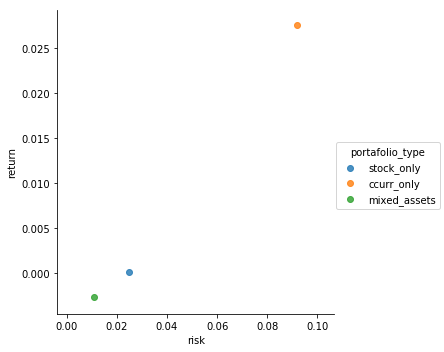

In [77]:
sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

### GA optimization vs Random Simulations

* Looking at the outcome plots of GA and Random simulation respectevaly, the main difference between these both is that GA allows a higher degree of the hyperspace exploration (Hyperspace is defined as the space where the possible silution are located), hence in GA the degree of exploting is lower, which enhaces the searching for global maximums.

* This might not be the case, but for portfolios composed by a signifacnlty higher number of assets, a random simulation dynamic is not suitable due this is considered a NP problem (not polynomial complexity problem in execution time).

## Optimizations(t) 

Once the optmization model is explained, the goal goes towards evaluate the protfolios behaviour in time.


** GA displacing time_window: ** It seeks to evaluate temporal behaviour considering a prefixed time_window displacing lags

In [95]:
tempos = dict()
num_iterations = 20

# Initialy we consider the lag per iteration with the same value of pre_fixed_time_window
lag_step_size, pre_fixed_time_window = 1, 30

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

last_date = percent_returns_pd.index[-1]

for i in range(1,num_iterations+1):
    print((num_iterations-i)*lag_step_size, pre_fixed_time_window)
    df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval((num_iterations-i)*lag_step_size, pre_fixed_time_window, True)
    ga_stock_frontier,ga_ccur_frontier,ga_mixed_frontier = drawing_frontier(df_ga_stock_output), drawing_frontier(df_ga_ccur_output), drawing_frontier(df_ga_output)
   
    ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
    ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
    ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)
    
    partition_date = (datetime.strptime(last_date, '%Y-%m-%d') + relativedelta(days = -((num_iterations-i)*lag_step_size))).strftime('%Y-%m-%d')
    tempos[partition_date] = dict()
    tempos[partition_date]['stock_frontier'] = ga_stock_frontier
    tempos[partition_date]['ccur_frontier'] = ga_ccur_frontier
    tempos[partition_date]['mixed_frontier'] = ga_mixed_frontier

19 30
##DF LAG#### 351 381


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min       	max       
0  	500   	-0.0153993	0.0018116	-0.0227401	-0.0112088
1  	292   	-0.0142824	0.00153992	-0.0233209	-0.0112088
2  	304   	-0.0136341	0.00156102	-0.0205997	-0.0108642
3  	317   	-0.0130688	0.00175512	-0.0253904	-0.0105347
4  	311   	-0.0125794	0.00176036	-0.0255005	-0.0102531
5  	304   	-0.0121276	0.00166398	-0.0246394	-0.0102531
6  	299   	-0.0118054	0.00167653	-0.0252938	-0.00988473
7  	297   	-0.0117198	0.00187802	-0.0286471	-0.00987085
8  	284   	-0.0116706	0.00234604	-0.0310151	-0.00981953
9  	262   	-0.0113483	0.00190929	-0.0227218	-0.0098594 
10 	314   	-0.0112338	0.00216416	-0.0287561	-0.00977426
11 	311   	-0.0110775	0.00191215	-0.0227387	-0.00977426
12 	300   	-0.010829 	0.00195072	-0.0249752	-0.0097281 
13 	306   	-0.0107401	0.00199496	-0.0287305	-0.00947099
14 	289   	-0.0106678	0.0028678 	-0.0589526	-0.00961901
15 	297   	-0.0105549	0.00205509	-0.0227969	-0.00943922
16 	291   	-0.010824 	0.00251701	-0.0261875	-0.00958773
1

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min      	max      
0  	500   	-0.0880121	0.00468283	-0.100099	-0.074253
1  	291   	-0.0847001	0.00508644	-0.112521	-0.0738624
2  	300   	-0.0819275	0.00504998	-0.109602	-0.0703058
3  	320   	-0.0796033	0.00493963	-0.126671	-0.0680872
4  	314   	-0.0776806	0.00493996	-0.113261	-0.0667025
5  	280   	-0.0761442	0.00565914	-0.10425 	-0.0664324
6  	324   	-0.0745926	0.00635268	-0.121068	-0.0652006
7  	314   	-0.0733505	0.00750332	-0.127628	-0.0630508
8  	294   	-0.0717841	0.00733147	-0.146264	-0.0630508
9  	311   	-0.0711477	0.00847154	-0.120319	-0.0617035
10 	291   	-0.0705498	0.00970349	-0.130173	-0.0635911
11 	280   	-0.0700027	0.0108381 	-0.159223	-0.0617775
12 	311   	-0.0695168	0.0105534 	-0.151756	-0.0617357
13 	295   	-0.0688238	0.0101194 	-0.119364	-0.0615093
14 	288   	-0.0679123	0.0105732 	-0.148928	-0.0615093
15 	299   	-0.0676901	0.0111229 	-0.128464	-0.0001   
16 	309   	-0.0681536	0.0123175 	-0.133694	-0.0615093
17 	287   	-0.0669797	0.012395

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min      	max      
0  	500   	-0.0367368	0.00433484	-0.051703	-0.024986
1  	299   	-0.0330708	0.00402358	-0.0485486	-0.0198399
2  	289   	-0.0299106	0.00451843	-0.0539124	-0.0147051
3  	302   	-0.0267474	0.00456604	-0.0488005	-0.0147051
4  	292   	-0.0244639	0.00514979	-0.0500267	-0.0145075
5  	316   	-0.0227649	0.00588645	-0.0565509	-0.0130297
6  	300   	-0.0205679	0.00508034	-0.0469732	-0.0130297
7  	314   	-0.0202396	0.00643279	-0.0479295	-0.0130297
8  	304   	-0.0184172	0.00600701	-0.0535643	-0.0130297
9  	283   	-0.0178239	0.00685665	-0.0591578	-0.0124534
10 	301   	-0.0168578	0.00619648	-0.0454474	-0.0114382
11 	298   	-0.0161708	0.00617712	-0.0483577	-0.0109848
12 	304   	-0.0167242	0.00773237	-0.0541932	-0.0109848
13 	292   	-0.0161532	0.00722662	-0.047834 	-0.0109848
14 	303   	-0.0154907	0.00708507	-0.0561793	-0.0109794
15 	308   	-0.0156795	0.00794449	-0.0640318	-0.0109794
16 	290   	-0.0155351	0.00829172	-0.0740103	-0.0109721
17 	305   	-0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0141179	0.00147108	-0.0211136	-0.0105985
1  	297   	-0.0132704	0.00154514	-0.0225211	-0.01006  
2  	305   	-0.0125957	0.0015996 	-0.0221965	-0.00995985
3  	297   	-0.0119003	0.00154206	-0.024323 	-0.00984748
4  	270   	-0.0115033	0.00169934	-0.0257472	-0.00949072
5  	301   	-0.0111288	0.00161296	-0.0237543	-0.00935651
6  	294   	-0.0109307	0.00185716	-0.0284139	-0.00906737
7  	288   	-0.0106046	0.0018623 	-0.0304606	-0.00900081
8  	306   	-0.0105246	0.00184988	-0.0219526	-0.00899386
9  	297   	-0.0106375	0.00307246	-0.0510578	-0.00891318
10 	291   	-0.0103559	0.00318399	-0.0510578	-0.00877906
11 	291   	-0.00997086	0.00192787	-0.0260047	-0.00867012
12 	303   	-0.0101659 	0.00247167	-0.0298985	-0.00867012
13 	292   	-0.0100705 	0.00265305	-0.0279519	-0.00867012
14 	283   	-0.00985501	0.00227153	-0.0280218	-0.00864513
15 	318   	-0.00966071	0.00207683	-0.0241218	-0.00859405
16 	297   	-0.00995136	0.00268795	-0.0285702	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min      	max     
0  	500   	-0.0899486	0.00458887	-0.107508	-0.07843
1  	301   	-0.0866547	0.00408314	-0.109258	-0.0716317
2  	263   	-0.084097 	0.00440743	-0.108536	-0.0716317
3  	325   	-0.0816368	0.00496371	-0.109319	-0.0695007
4  	293   	-0.0798898	0.00677381	-0.128219	-0.0684222
5  	302   	-0.0779834	0.00628752	-0.129988	-0.0678351
6  	301   	-0.076264 	0.00734115	-0.126415	-0.0663017
7  	290   	-0.0754684	0.0084186 	-0.124537	-0.0664935
8  	286   	-0.0734065	0.00789742	-0.127853	-0.0660284
9  	305   	-0.073091 	0.00939372	-0.148482	-0.0660284
10 	277   	-0.0721575	0.0089033 	-0.112624	-0.0652174
11 	293   	-0.0716108	0.00937705	-0.123885	-0.0652174
12 	264   	-0.071742 	0.0120757 	-0.171987	-0.0651716
13 	304   	-0.0724957	0.0146487 	-0.171987	-0.0651716
14 	303   	-0.0709853	0.0120158 	-0.1661  	-0.0651716
15 	324   	-0.0715917	0.0135067 	-0.168562	-0.0651716
16 	314   	-0.0711975	0.0139268 	-0.1661  	-0.0001   
17 	312   	-0.0711534	0.0147512 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0335562	0.00401567	-0.0474459	-0.0220758
1  	282   	-0.0301625	0.00403351	-0.0433609	-0.0165641
2  	306   	-0.0272496	0.00444284	-0.0490624	-0.0114128
3  	306   	-0.0245145	0.00468808	-0.0527522	-0.012742 
4  	308   	-0.0219219	0.00470073	-0.043484 	-0.0112672
5  	282   	-0.0200076	0.00491128	-0.0445237	-0.0112672
6  	289   	-0.0183548	0.00513177	-0.0436522	-0.0111803
7  	283   	-0.0170333	0.00535473	-0.0431414	-0.0109702
8  	313   	-0.0163015	0.00616118	-0.0493987	-0.0105099
9  	304   	-0.0153519	0.00595431	-0.0411685	-0.0105303
10 	284   	-0.0152229	0.00715111	-0.0520631	-0.010543 
11 	295   	-0.0146165	0.00654201	-0.0449618	-0.0101191
12 	291   	-0.0141292	0.00680636	-0.0451186	-0.00987749
13 	309   	-0.0143074	0.00722138	-0.0470489	-0.00977898
14 	299   	-0.0140475	0.0074567 	-0.0444461	-0.00977898
15 	320   	-0.0141628	0.00760102	-0.047395 	-0.00973633
16 	287   	-0.013218 	0.00691869	-0.0463927	-0.00954378
17 	3

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std       	min      	max       
0  	500   	-0.01439	0.00167645	-0.022294	-0.0104833
1  	298   	-0.0133745	0.00158761	-0.0238942	-0.0101467
2  	299   	-0.0127301	0.00151219	-0.0231261	-0.0104866
3  	299   	-0.0122208	0.00146789	-0.0232686	-0.00986479
4  	314   	-0.0118266	0.00169661	-0.0231744	-0.00878811
5  	310   	-0.0115003	0.00182614	-0.0243593	-0.00878811
6  	268   	-0.0110337	0.00144101	-0.0214791	-0.00878811
7  	335   	-0.0111409	0.00243723	-0.0339022	-0.00878811
8  	314   	-0.0108259	0.00234316	-0.0351388	-0.00878811
9  	291   	-0.0106693	0.00248137	-0.0430135	-0.00876175
10 	304   	-0.0105632	0.0026262 	-0.0342441	-0.00876175
11 	306   	-0.0101138	0.00202806	-0.0244702	-0.00868814
12 	295   	-0.0100613	0.00224154	-0.0211057	-0.00868814
13 	309   	-0.00995576	0.00255313	-0.0290874	-0.00866927
14 	288   	-0.00986573	0.00235488	-0.0238016	-0.00862954
15 	327   	-0.00977958	0.00234639	-0.0197254	-0.0086367 
16 	289   	-0.00979104	0.00259135	-0.0383664	-0.0086367

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min      	max       
0  	500   	-0.0884741	0.00458287	-0.103698	-0.0753646
1  	310   	-0.085325 	0.0048029 	-0.114819	-0.0741851
2  	285   	-0.082479 	0.00439253	-0.109654	-0.0691312
3  	286   	-0.0799344	0.00477742	-0.112022	-0.0690847
4  	302   	-0.0779675	0.00551278	-0.115703	-0.0672325
5  	308   	-0.0766512	0.00705748	-0.130244	-0.0672325
6  	286   	-0.0744439	0.00594572	-0.115727	-0.0657397
7  	293   	-0.07312  	0.00681013	-0.121846	-0.0661642
8  	294   	-0.0718549	0.00727398	-0.11833 	-0.0657024
9  	300   	-0.0713956	0.00856437	-0.127591	-0.0652748
10 	298   	-0.0706619	0.00871672	-0.151708	-0.0650552
11 	315   	-0.0705285	0.00856963	-0.120835	-0.0650552
12 	297   	-0.0697662	0.00891826	-0.114194	-0.0650552
13 	300   	-0.0697166	0.00928549	-0.142406	-0.0649478
14 	288   	-0.0694919	0.00976545	-0.127625	-0.064943 
15 	288   	-0.0697212	0.00981769	-0.116559	-0.0648852
16 	299   	-0.0700763	0.0105469 	-0.123746	-0.0648657
17 	311   	-0.0699986	0.0116

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0343037	0.00410193	-0.0467221	-0.0196116
1  	295   	-0.0308029	0.00404719	-0.0538172	-0.0168319
2  	325   	-0.0274789	0.00403576	-0.0433147	-0.0167561
3  	315   	-0.0246765	0.0044854 	-0.0479179	-0.0152919
4  	295   	-0.022566 	0.00489616	-0.048757 	-0.0134236
5  	301   	-0.0207629	0.00510604	-0.0478397	-0.0124716
6  	280   	-0.0190284	0.00506378	-0.0443138	-0.011328 
7  	307   	-0.0179165	0.00519757	-0.0516359	-0.0118942
8  	281   	-0.0173415	0.00615915	-0.0527655	-0.0114137
9  	321   	-0.0168189	0.00654106	-0.0561713	-0.0105412
10 	309   	-0.0162951	0.00711356	-0.0572318	-0.0105412
11 	302   	-0.0152158	0.00609577	-0.0502404	-0.0108923
12 	284   	-0.0150137	0.00673574	-0.0452965	-0.0108883
13 	270   	-0.0150656	0.00747388	-0.0511918	-0.0104881
14 	313   	-0.0146815	0.00737574	-0.0509674	-0.00981965
15 	300   	-0.0147943	0.00776834	-0.0493885	-0.0100199 
16 	306   	-0.0148704	0.0083889 	-0.0516236	-0.0100887 
17 	31

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0141778	0.00148923	-0.0205923	-0.0113083
1  	307   	-0.0133128	0.00146947	-0.0212367	-0.0103184
2  	292   	-0.0128027	0.00184211	-0.0307149	-0.0103411
3  	282   	-0.0122018	0.00132932	-0.0239142	-0.0103188
4  	294   	-0.0119045	0.00156136	-0.0216442	-0.0100834
5  	283   	-0.0115161	0.00154452	-0.0213676	-0.0100075
6  	299   	-0.0112659	0.00156965	-0.0238667	-0.00994856
7  	291   	-0.0112652	0.00200905	-0.028134 	-0.00982513
8  	293   	-0.0108028	0.00130592	-0.0195335	-0.00965723
9  	290   	-0.0110037	0.00189739	-0.0222756	-0.00965723
10 	317   	-0.0108841	0.00192952	-0.0249699	-0.00968527
11 	320   	-0.0108148	0.00190003	-0.0214736	-0.00964262
12 	307   	-0.0106642	0.00184063	-0.0243169	-0.0095345 
13 	304   	-0.0105025	0.00161486	-0.0184781	-0.0095345 
14 	312   	-0.0107284	0.00224742	-0.0259513	-0.0095345 
15 	326   	-0.0106711	0.0025734 	-0.0475253	-0.00939316
16 	283   	-0.0103521	0.00181507	-0.0243491	-0.00939316

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min      	max       
0  	500   	-0.0895988	0.00428767	-0.102325	-0.0751044
1  	311   	-0.0865342	0.00469217	-0.11518 	-0.0743228
2  	311   	-0.0838244	0.00463268	-0.103776	-0.070844 
3  	316   	-0.0811929	0.00547985	-0.138368	-0.0689706
4  	300   	-0.0791022	0.00584013	-0.112242	-0.0671126
5  	269   	-0.0769511	0.00681935	-0.139897	-0.0662977
6  	272   	-0.0744966	0.00700826	-0.111484	-0.0001   
7  	319   	-0.07393  	0.00745976	-0.118946	-0.0662977
8  	322   	-0.0727274	0.00693655	-0.11971 	-0.0662977
9  	307   	-0.0717686	0.00756135	-0.113847	-0.0660967
10 	317   	-0.0713128	0.00826118	-0.140622	-0.0654448
11 	270   	-0.0700628	0.00829607	-0.122298	-0.0001   
12 	322   	-0.0712482	0.0105728 	-0.132517	-0.0001   
13 	308   	-0.0712326	0.012344  	-0.161466	-0.0001   
14 	295   	-0.0698282	0.012579  	-0.15254 	-0.0001   
15 	306   	-0.0698475	0.0137903 	-0.15254 	-0.0001   
16 	313   	-0.0697706	0.0167192 	-0.161466	-0.0001   
17 	314   	-0.0695791	0.0175

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0332043	0.00389226	-0.0453732	-0.0223196
1  	284   	-0.0299073	0.00345681	-0.0494379	-0.0183899
2  	283   	-0.027532 	0.00378537	-0.0443728	-0.014808 
3  	313   	-0.02521  	0.00416915	-0.0513155	-0.0144216
4  	285   	-0.0228717	0.00460383	-0.05077  	-0.0131404
5  	317   	-0.0212037	0.00500533	-0.0531485	-0.0124322
6  	298   	-0.019095 	0.00513308	-0.0472249	-0.0119851
7  	285   	-0.0178919	0.00539702	-0.0413243	-0.0119271
8  	305   	-0.016851 	0.00567532	-0.042315 	-0.0110909
9  	292   	-0.0163708	0.00652574	-0.0508261	-0.0110813
10 	303   	-0.0160914	0.0072304 	-0.0491995	-0.0110052
11 	298   	-0.0155983	0.00680679	-0.0410913	-0.0106525
12 	293   	-0.0148282	0.00685024	-0.0445841	-0.0102872
13 	295   	-0.0151205	0.00768478	-0.0494766	-0.0101647
14 	309   	-0.0148213	0.00814338	-0.058329 	-0.00988993
15 	299   	-0.0142345	0.0074825 	-0.0456979	-0.00988993
16 	296   	-0.014305 	0.00798154	-0.0476789	-0.0097239 
17 	323

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min     	max        
0  	500   	-0.0127189	0.00126335	-0.01744	-0.00972031
1  	306   	-0.0120703	0.00153189	-0.0256358	-0.00952804
2  	299   	-0.0115725	0.00130206	-0.0187912	-0.00952804
3  	315   	-0.0111373	0.00125975	-0.0179797	-0.00917533
4  	291   	-0.0107668	0.00150782	-0.0272614	-0.00922843
5  	314   	-0.0104558	0.00141194	-0.0206899	-0.00907598
6  	289   	-0.0102149	0.00158004	-0.023521 	-0.00883999
7  	287   	-0.0100836	0.00169055	-0.0294435	-0.00883999
8  	293   	-0.00989445	0.00137723	-0.0192332	-0.0088165 
9  	292   	-0.00992209	0.00162906	-0.020607 	-0.00878746
10 	312   	-0.00993092	0.00229054	-0.0336188	-0.00859823
11 	303   	-0.00967247	0.00150241	-0.0194085	-0.00859823
12 	296   	-0.00980152	0.00201119	-0.022047 	-0.00856921
13 	304   	-0.00947699	0.00170663	-0.0219557	-0.00856921
14 	287   	-0.0095253 	0.00208988	-0.0313341	-0.00856921
15 	303   	-0.00937097	0.00161534	-0.0196615	-0.00856136
16 	306   	-0.00949975	0.0020906 	-0.0230072

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0861135	0.00417878	-0.0998337	-0.0735627
1  	297   	-0.0829394	0.00413862	-0.107393 	-0.0684907
2  	299   	-0.0803067	0.00407197	-0.110292 	-0.067153 
3  	316   	-0.0779102	0.00463758	-0.10291  	-0.0655948
4  	286   	-0.0759915	0.00563305	-0.132317 	-0.0658401
5  	258   	-0.0741014	0.00553043	-0.100195 	-0.0652192
6  	284   	-0.0724578	0.00643498	-0.114463 	-0.0640077
7  	325   	-0.0715706	0.00723264	-0.106755 	-0.0637354
8  	320   	-0.069995 	0.00728592	-0.113871 	-0.0635663
9  	294   	-0.0689846	0.00794721	-0.129414 	-0.063166 
10 	290   	-0.0684954	0.00878719	-0.128946 	-0.063166 
11 	296   	-0.0678748	0.00941008	-0.152738 	-0.0629588
12 	282   	-0.0673127	0.00839932	-0.117352 	-0.0629685
13 	293   	-0.0668752	0.00856916	-0.1273   	-0.0629065
14 	284   	-0.0667119	0.0087827 	-0.147465 	-0.0628068
15 	295   	-0.0664463	0.00877005	-0.105185 	-0.0001   
16 	308   	-0.0666924	0.00908347	-0.135727 	-0.0628068
17 	282   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



gen	nevals	avg      	std      	min       	max       
0  	500   	-0.031849	0.0041788	-0.0465926	-0.0219399
1  	283   	-0.0284987	0.00387348	-0.0444485	-0.0179116
2  	321   	-0.0256161	0.00417695	-0.0429309	-0.0129539
3  	304   	-0.0228782	0.00432493	-0.0439788	-0.012162 
4  	326   	-0.0208488	0.00479235	-0.0445447	-0.012442 
5  	314   	-0.018598 	0.00455471	-0.0450694	-0.0108847
6  	307   	-0.0172764	0.00530752	-0.0466781	-0.0110717
7  	298   	-0.0163893	0.00557605	-0.039098 	-0.0108519
8  	315   	-0.0148426	0.00477515	-0.0424102	-0.0101547
9  	306   	-0.0145574	0.00555273	-0.0425952	-0.0099061
10 	305   	-0.0143608	0.0062555 	-0.0490599	-0.00942862
11 	293   	-0.0137327	0.0057455 	-0.0390971	-0.00942862
12 	304   	-0.0134743	0.00613189	-0.0418559	-0.00925015
13 	278   	-0.0133351	0.0063246 	-0.0399565	-0.00925015
14 	308   	-0.0128531	0.00687617	-0.0536386	-0.00920244
15 	300   	-0.0133853	0.00755047	-0.0515121	-0.00882992
16 	307   	-0.013528 	0.00779932	-0.0458175	-0.00882885
17 	29

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max        
0  	500   	-0.0126509	0.00134767	-0.0181347	-0.00966074
1  	311   	-0.011787 	0.00133375	-0.0184011	-0.00883293
2  	299   	-0.0110591	0.00115099	-0.0177829	-0.00883293
3  	297   	-0.0105361	0.0010983 	-0.0173712	-0.00889585
4  	328   	-0.0102112	0.00132482	-0.0215104	-0.00879737
5  	280   	-0.0099382	0.00147329	-0.0209293	-0.00874203
6  	273   	-0.00969009	0.00157383	-0.0260504	-0.00864633
7  	279   	-0.0095099 	0.00140886	-0.0182286	-0.00855073
8  	283   	-0.00942137	0.00146966	-0.0224034	-0.0085274 
9  	294   	-0.00935954	0.00157382	-0.0189473	-0.00851824
10 	310   	-0.00926703	0.00164967	-0.0244024	-0.008447  
11 	288   	-0.00919592	0.00159885	-0.022786 	-0.008447  
12 	318   	-0.00910069	0.00133332	-0.0194475	-0.00838396
13 	329   	-0.0092287 	0.00158444	-0.0192627	-0.00837762
14 	325   	-0.00921884	0.00180554	-0.0238552	-0.00832969
15 	281   	-0.00917683	0.00180061	-0.0193811	-0.00833219
16 	311   	-0.00889036	0.00126355	-0.0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0812569	0.00475101	-0.0967427	-0.0690265
1  	287   	-0.0777999	0.00481566	-0.120848 	-0.0658282
2  	298   	-0.0748328	0.00467211	-0.0988967	-0.0614408
3  	280   	-0.072309 	0.00594087	-0.141267 	-0.0614408
4  	314   	-0.0699525	0.0051952 	-0.114218 	-0.0595724
5  	264   	-0.0678641	0.006144  	-0.111153 	-0.0577376
6  	309   	-0.0663526	0.00746754	-0.117377 	-0.0567159
7  	293   	-0.0648443	0.00744323	-0.109158 	-0.0567159
8  	287   	-0.063932 	0.00904331	-0.133359 	-0.0565678
9  	287   	-0.0634915	0.00931099	-0.110855 	-0.0565678
10 	269   	-0.0618324	0.00920538	-0.137348 	-0.0564936
11 	299   	-0.0616312	0.0102043 	-0.136064 	-0.0001   
12 	293   	-0.0611869	0.0113397 	-0.137348 	-0.0001   
13 	282   	-0.0595871	0.0113075 	-0.13805  	-0.0001   
14 	305   	-0.059354 	0.0115344 	-0.10344  	-0.0001   
15 	299   	-0.0590146	0.0168194 	-0.126569 	-0.0001   
16 	305   	-0.0569937	0.0203271 	-0.139334 	-0.0001   
17 	291  

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0315316	0.00425037	-0.0452004	-0.0177521
1  	282   	-0.0280517	0.00376679	-0.0418459	-0.0137747
2  	305   	-0.0252676	0.00368151	-0.0428518	-0.0131899
3  	279   	-0.0228123	0.00395109	-0.0402557	-0.013048 
4  	273   	-0.0207963	0.00441566	-0.0462819	-0.0130464
5  	294   	-0.0187531	0.00487547	-0.0465933	-0.0111346
6  	308   	-0.016831 	0.00459771	-0.0447931	-0.0105564
7  	291   	-0.0157502	0.00534456	-0.0552599	-0.0101562
8  	293   	-0.0147823	0.00477699	-0.0388681	-0.0101562
9  	295   	-0.0147388	0.00603266	-0.0470881	-0.00998011
10 	292   	-0.0137278	0.00511886	-0.0401324	-0.0100345 
11 	286   	-0.0134629	0.00565046	-0.0402305	-0.00967241
12 	294   	-0.012947 	0.00566698	-0.0514228	-0.00964198
13 	296   	-0.0129562	0.00610463	-0.0416035	-0.00926506
14 	326   	-0.0133744	0.00699421	-0.0417245	-0.00916234
15 	295   	-0.0131753	0.00714505	-0.0455934	-0.00873808
16 	306   	-0.0130666	0.00733379	-0.0485917	-0.00873808
17

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max        
0  	500   	-0.0120219	0.00115477	-0.0168769	-0.00929169
1  	309   	-0.011258 	0.0010054 	-0.0167189	-0.00896923
2  	299   	-0.0107839	0.0010108 	-0.0170801	-0.00890663
3  	305   	-0.0103406	0.000984974	-0.016764 	-0.00890663
4  	288   	-0.0100152	0.00108756 	-0.0202339	-0.0087511 
5  	290   	-0.0099166	0.00122461 	-0.0190651	-0.00868996
6  	301   	-0.00968971	0.00121124 	-0.0167839	-0.008296  
7  	305   	-0.00966779	0.00182686 	-0.0353775	-0.008296  
8  	308   	-0.00946784	0.00152362 	-0.020303 	-0.008296  
9  	294   	-0.00940485	0.00174261 	-0.0210008	-0.00806836
10 	299   	-0.0094004 	0.0018393  	-0.0243219	-0.0079939 
11 	304   	-0.00939804	0.0019434  	-0.0216247	-0.00802564
12 	310   	-0.00940907	0.00236863 	-0.0290489	-0.00798815
13 	283   	-0.00933375	0.00268618 	-0.028185 	-0.0001    
14 	295   	-0.00917047	0.00250578 	-0.022957 	-0.0001    
15 	303   	-0.0092643 	0.00312576 	-0.0400808	-0.0001    
16 	305   	-0.00928899	0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min      	max       
0  	500   	-0.0846511	0.00461137	-0.100038	-0.0696204
1  	290   	-0.0815048	0.00451089	-0.102544	-0.0696204
2  	283   	-0.0784162	0.00488053	-0.11716 	-0.0649009
3  	308   	-0.0758235	0.00479163	-0.108671	-0.0639336
4  	313   	-0.0736294	0.00518649	-0.123467	-0.0633525
5  	295   	-0.0719068	0.00506686	-0.100921	-0.0633525
6  	311   	-0.0703832	0.00606039	-0.114079	-0.0633525
7  	281   	-0.0689231	0.0070459 	-0.127334	-0.0632543
8  	282   	-0.0680788	0.00771247	-0.118644	-0.0625354
9  	298   	-0.0673992	0.00793968	-0.142465	-0.0623268
10 	324   	-0.0673221	0.0090746 	-0.12145 	-0.062345 
11 	327   	-0.0675102	0.00987092	-0.156407	-0.0622366
12 	308   	-0.0662289	0.00742954	-0.097469	-0.0622085
13 	297   	-0.0659968	0.00817297	-0.103773	-0.0001   
14 	290   	-0.066708 	0.0108433 	-0.158906	-0.0001   
15 	310   	-0.0665726	0.0102775 	-0.12742 	-0.0001   
16 	301   	-0.0664477	0.0116138 	-0.116723	-0.0001   
17 	302   	-0.0644956	0.0152

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0322422	0.00423612	-0.0477247	-0.0201894
1  	306   	-0.0289675	0.00425899	-0.0698106	-0.0184861
2  	310   	-0.0260347	0.003718  	-0.0549663	-0.0129812
3  	311   	-0.0237496	0.00409662	-0.0429359	-0.0129812
4  	321   	-0.0216673	0.00488659	-0.0442236	-0.0123042
5  	302   	-0.0193965	0.00469192	-0.0402082	-0.0102559
6  	315   	-0.0176974	0.00488173	-0.0474188	-0.0102559
7  	297   	-0.0167103	0.00586061	-0.0495133	-0.00960086
8  	293   	-0.0151733	0.00536038	-0.0412589	-0.00960086
9  	315   	-0.0144316	0.00559569	-0.0437602	-0.00898627
10 	297   	-0.0136525	0.00577538	-0.0436956	-0.00898627
11 	299   	-0.0132956	0.00587969	-0.0513468	-0.00898627
12 	286   	-0.0127379	0.00558426	-0.0383662	-0.00898627
13 	325   	-0.0130865	0.00660101	-0.0384166	-0.0084615 
14 	291   	-0.0128015	0.00696911	-0.0481785	-0.00826173
15 	295   	-0.0123806	0.00672012	-0.0446832	-0.00826173
16 	303   	-0.0121391	0.00674297	-0.0541218	-0.00818955


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max        
0  	500   	-0.0118138	0.00100956	-0.0153888	-0.00950432
1  	318   	-0.0112689	0.00124368	-0.0187711	-0.00919138
2  	286   	-0.010603 	0.000979885	-0.0188697	-0.00895611
3  	283   	-0.0102168	0.00107904 	-0.0228677	-0.00881918
4  	290   	-0.00987237	0.000857447	-0.0151106	-0.00867225
5  	303   	-0.00980645	0.00153329 	-0.0250986	-0.00820855
6  	320   	-0.00972054	0.0012951  	-0.017716 	-0.00822517
7  	292   	-0.00953682	0.00138093 	-0.0173843	-0.00822517
8  	310   	-0.00945365	0.00150796 	-0.0212523	-0.00816929
9  	302   	-0.00929942	0.00160948 	-0.0270819	-0.00753986
10 	310   	-0.00914576	0.0014398  	-0.0182477	-0.00753986
11 	292   	-0.00904209	0.00161179 	-0.0219808	-0.00753986
12 	322   	-0.00921656	0.00200456 	-0.0240017	-0.00753986
13 	315   	-0.00909226	0.00226496 	-0.0266902	-0.0075153 
14 	288   	-0.00879138	0.0018465  	-0.0201193	-0.00745499
15 	306   	-0.00877381	0.00210118 	-0.0230489	-0.00743428
16 	311   	-0.00886046

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0811432	0.00399561	-0.0974553	-0.0709214
1  	294   	-0.0782825	0.00395788	-0.0974612	-0.0654511
2  	296   	-0.0757935	0.00396522	-0.0931827	-0.0656861
3  	283   	-0.0743508	0.00553205	-0.115859 	-0.0637832
4  	299   	-0.071847 	0.00465099	-0.1113   	-0.0634043
5  	296   	-0.0701101	0.00469185	-0.111106 	-0.0621972
6  	283   	-0.0685527	0.0048921 	-0.108387 	-0.0621341
7  	288   	-0.0677702	0.0060491 	-0.106128 	-0.0616908
8  	272   	-0.0669137	0.00675502	-0.136096 	-0.0616908
9  	295   	-0.0664163	0.00764231	-0.153618 	-0.0610634
10 	270   	-0.0658409	0.00755078	-0.117944 	-0.0610106
11 	293   	-0.0666103	0.0109099 	-0.155911 	-0.0001   
12 	310   	-0.065641 	0.0105121 	-0.128949 	-0.0001   
13 	302   	-0.0646993	0.0128002 	-0.137287 	-0.0001   
14 	326   	-0.0650703	0.0159513 	-0.137508 	-0.0001   
15 	301   	-0.0630726	0.0190985 	-0.155911 	-0.0001   
16 	288   	-0.061139 	0.0204412 	-0.155911 	-0.0001   
17 	311   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min       	max       
0  	500   	-0.0314557	0.0040522	-0.0444193	-0.0217186
1  	315   	-0.0281384	0.0039142	-0.0473497	-0.0172396
2  	294   	-0.0251861	0.00353373	-0.0379336	-0.0118826
3  	306   	-0.022766 	0.00407275	-0.0437792	-0.0118826
4  	291   	-0.0208043	0.00448227	-0.0410489	-0.0100531
5  	299   	-0.0188326	0.00542485	-0.0546582	-0.00997024
6  	297   	-0.0170362	0.0058087 	-0.0499951	-0.00979532
7  	315   	-0.015939 	0.00615681	-0.044035 	-0.00979532
8  	301   	-0.0150783	0.00638898	-0.041451 	-0.00920667
9  	304   	-0.0137854	0.00618279	-0.0434046	-0.0092436 
10 	296   	-0.0138181	0.00678681	-0.0521378	-0.0092436 
11 	311   	-0.0132164	0.00679339	-0.0425198	-0.00858334
12 	312   	-0.0130903	0.00669988	-0.047518 	-0.00853804
13 	299   	-0.0129022	0.00742676	-0.0494499	-0.00853804
14 	303   	-0.0129526	0.00765753	-0.0474463	-0.00839328
15 	309   	-0.0123599	0.00729676	-0.0409295	-0.00829315
16 	265   	-0.0122199	0.0079187 	-0.0552998	-0.00811607
1

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min      	max        
0  	500   	-0.0117085	0.00107181	-0.015081	-0.00909063
1  	303   	-0.011045 	0.00114243	-0.0203954	-0.00884049
2  	289   	-0.0105014	0.00102798	-0.0176627	-0.00882085
3  	294   	-0.0101233	0.00103096	-0.0180072	-0.00853798
4  	289   	-0.00983865	0.00107342	-0.0169469	-0.00830748
5  	274   	-0.00957863	0.000980114	-0.016728 	-0.00835251
6  	294   	-0.00946508	0.0012377  	-0.0213208	-0.00832059
7  	298   	-0.00937068	0.00131574 	-0.0187314	-0.00810199
8  	323   	-0.00926273	0.00146566 	-0.0192379	-0.00809444
9  	305   	-0.00925051	0.00154006 	-0.0163353	-0.00809444
10 	310   	-0.00918571	0.00169783 	-0.0267541	-0.00807885
11 	334   	-0.00889109	0.00146969 	-0.0206902	-0.00781817
12 	294   	-0.00902689	0.00188324 	-0.0246988	-0.00781817
13 	331   	-0.00902801	0.00214978 	-0.0224263	-0.00781817
14 	292   	-0.00904992	0.00219381 	-0.0233006	-0.0077772 
15 	305   	-0.00889027	0.00212356 	-0.0254579	-0.00775718
16 	285   	-0.00907389	0.00

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0816011	0.00418073	-0.0978753	-0.0690235
1  	284   	-0.0784931	0.0045382 	-0.10979  	-0.0647062
2  	324   	-0.0758379	0.00396689	-0.0956731	-0.0631648
3  	311   	-0.0739687	0.00451866	-0.104611 	-0.0631648
4  	313   	-0.0722109	0.00481874	-0.0991312	-0.0625779
5  	300   	-0.0707861	0.00543388	-0.121526 	-0.0623183
6  	314   	-0.0692168	0.0053308 	-0.105296 	-0.06195  
7  	296   	-0.067994 	0.00567314	-0.107982 	-0.0616781
8  	289   	-0.0675205	0.00706256	-0.140198 	-0.0616781
9  	308   	-0.0668742	0.0072177 	-0.108087 	-0.0613926
10 	285   	-0.0660807	0.00905775	-0.152291 	-0.0001   
11 	296   	-0.0657393	0.00997818	-0.143837 	-0.0001   
12 	296   	-0.0654167	0.00797675	-0.104732 	-0.0001   
13 	301   	-0.0649069	0.00921522	-0.114122 	-0.0001   
14 	322   	-0.0650393	0.0111679 	-0.140198 	-0.0001   
15 	307   	-0.0644482	0.0133187 	-0.142658 	-0.0001   
16 	276   	-0.0627664	0.0162642 	-0.140198 	-0.0001   
17 	311   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0332878	0.00428872	-0.0468207	-0.0218365
1  	308   	-0.0298831	0.00442826	-0.0502549	-0.0164535
2  	296   	-0.0268548	0.00433256	-0.0532143	-0.015502 
3  	312   	-0.0242462	0.0047709 	-0.04922  	-0.0133766
4  	277   	-0.0217015	0.0051082 	-0.0515313	-0.012379 
5  	317   	-0.019645 	0.0055372 	-0.0560081	-0.011926 
6  	316   	-0.017722 	0.0054255 	-0.0446988	-0.0106615
7  	305   	-0.0169387	0.00637691	-0.0488213	-0.0101944
8  	268   	-0.0154729	0.00601933	-0.0484351	-0.0100458
9  	293   	-0.0147782	0.0066661 	-0.0573847	-0.00951579
10 	297   	-0.0139949	0.00642636	-0.0407716	-0.00910444
11 	315   	-0.0140943	0.00770315	-0.0549642	-0.00910444
12 	309   	-0.0135451	0.00720454	-0.0497778	-0.00895941
13 	300   	-0.0128333	0.00671681	-0.051097 	-0.00856687
14 	303   	-0.0130812	0.00778153	-0.048733 	-0.00856687
15 	262   	-0.0126482	0.00792682	-0.051299 	-0.00856397
16 	288   	-0.0124423	0.00772817	-0.0488344	-0.00853972
17

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std        	min       	max        
0  	500   	-0.0105675	0.000773949	-0.0134497	-0.00845029
1  	278   	-0.0101471	0.00100268 	-0.0180238	-0.00831392
2  	299   	-0.00963086	0.000787346	-0.0141336	-0.0078195 
3  	279   	-0.00927827	0.000784754	-0.0145566	-0.00763958
4  	326   	-0.00909525	0.0011756  	-0.0209993	-0.00778354
5  	298   	-0.00876307	0.000846715	-0.0138535	-0.00741561
6  	287   	-0.00873755	0.00142242 	-0.0233139	-0.00741561
7  	296   	-0.00837566	0.00113273 	-0.0230606	-0.00710261
8  	312   	-0.00836603	0.0013535  	-0.0188055	-0.00697993
9  	324   	-0.00826424	0.00148942 	-0.0251753	-0.00697993
10 	276   	-0.00807284	0.00122338 	-0.0160126	-0.00689097
11 	301   	-0.00804447	0.00175803 	-0.0246326	-0.00689097
12 	310   	-0.00785946	0.00144328 	-0.0186015	-0.00667053
13 	299   	-0.00774654	0.00149646 	-0.0170381	-0.00667053
14 	310   	-0.00778371	0.00170654 	-0.018628 	-0.00663962
15 	295   	-0.00759078	0.0014967  	-0.0171363	-0.00665011
16 	326   	-0.007

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min       	max       
0  	500   	-0.0818851	0.0039289	-0.0944562	-0.0722039
1  	315   	-0.0788008	0.00349624	-0.0934521	-0.0653282
2  	283   	-0.076644 	0.00454112	-0.103996 	-0.0639926
3  	312   	-0.0745362	0.00477842	-0.117789 	-0.0626786
4  	306   	-0.0727457	0.00500051	-0.101687 	-0.0626786
5  	309   	-0.0709575	0.00560119	-0.0994348	-0.0626786
6  	299   	-0.0693507	0.00663839	-0.142616 	-0.0625596
7  	291   	-0.0679402	0.00765886	-0.129346 	-0.0614236
8  	299   	-0.0674263	0.00769999	-0.109472 	-0.0615516
9  	318   	-0.0676316	0.00956601	-0.144821 	-0.0613825
10 	307   	-0.06665  	0.00932459	-0.141338 	-0.0613484
11 	314   	-0.066365 	0.00935334	-0.13333  	-0.0613484
12 	349   	-0.0666425	0.00966341	-0.119706 	-0.0611718
13 	302   	-0.0664726	0.0121273 	-0.141679 	-0.0611604
14 	302   	-0.0663034	0.0104028 	-0.144821 	-0.0611604
15 	314   	-0.0654388	0.00922244	-0.121237 	-0.0611552
16 	296   	-0.064958 	0.00938818	-0.113449 	-0.0001   
17 	286   	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0338052	0.00426428	-0.0483173	-0.0179947
1  	322   	-0.030301 	0.00417207	-0.0458839	-0.0153131
2  	302   	-0.0271615	0.00444971	-0.0441683	-0.0133259
3  	302   	-0.0241615	0.00469908	-0.0489609	-0.0120412
4  	280   	-0.0216027	0.00506745	-0.0425168	-0.0120412
5  	266   	-0.0190489	0.00465171	-0.0406287	-0.0112694
6  	298   	-0.0173822	0.00560744	-0.059999 	-0.00984644
7  	307   	-0.016099 	0.00608247	-0.0497911	-0.00975847
8  	307   	-0.0150554	0.00561869	-0.0398974	-0.00975847
9  	304   	-0.0143429	0.00630645	-0.0491738	-0.00928803
10 	307   	-0.0140205	0.00676258	-0.0446412	-0.00748065
11 	304   	-0.0136895	0.00702864	-0.0436135	-0.00748065
12 	281   	-0.0128789	0.00714491	-0.053846 	-0.00738664
13 	321   	-0.0129291	0.00762468	-0.0462518	-0.00738664
14 	280   	-0.0125877	0.00775449	-0.0500828	-0.00743532
15 	304   	-0.0127461	0.00822035	-0.053667 	-0.00743532
16 	292   	-0.0126213	0.00853267	-0.0494532	-0.00724391

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min       	max        
0  	500   	-0.0112076	0.0006594	-0.0135199	-0.00951207
1  	293   	-0.0108404	0.000711961	-0.0147438	-0.00930313
2  	288   	-0.0105173	0.000704743	-0.0145412	-0.00930313
3  	301   	-0.0103157	0.000868596	-0.0183212	-0.00910004
4  	313   	-0.010003 	0.0008408  	-0.0188529	-0.00902421
5  	307   	-0.00992648	0.000836008	-0.0158871	-0.00899026
6  	289   	-0.00983557	0.00113705 	-0.022133 	-0.00842184
7  	293   	-0.00966364	0.00101651 	-0.0181174	-0.0087791 
8  	293   	-0.00954315	0.000932437	-0.0163304	-0.00851707
9  	294   	-0.00949237	0.00106701 	-0.0200868	-0.00849581
10 	273   	-0.00949811	0.00131089 	-0.0176075	-0.00831374
11 	289   	-0.00937045	0.00124337 	-0.016569 	-0.00831374
12 	291   	-0.00936328	0.00162217 	-0.0264337	-0.00831259
13 	290   	-0.00929244	0.00156158 	-0.0236164	-0.00829503
14 	311   	-0.00916071	0.0015718  	-0.018959 	-0.0001    
15 	308   	-0.00916678	0.00176037 	-0.0210192	-0.0001    
16 	315   	-0.00901458	0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0814727	0.00371443	-0.0936994	-0.0699169
1  	301   	-0.0790268	0.00409764	-0.108873 	-0.0639268
2  	288   	-0.0767629	0.00373448	-0.109797 	-0.0661315
3  	322   	-0.0749685	0.00384401	-0.0960253	-0.0661315
4  	291   	-0.073254 	0.00451069	-0.102007 	-0.0631291
5  	318   	-0.0717674	0.00594991	-0.1505   	-0.0631291
6  	307   	-0.0706003	0.00609632	-0.111909 	-0.0624249
7  	293   	-0.0690212	0.00569272	-0.103006 	-0.0608166
8  	335   	-0.0684198	0.00677482	-0.122439 	-0.0608166
9  	311   	-0.067458 	0.00663292	-0.110489 	-0.0608166
10 	320   	-0.0665835	0.00608295	-0.122714 	-0.0608124
11 	315   	-0.0667537	0.00769347	-0.107867 	-0.0608124
12 	316   	-0.0666953	0.00842998	-0.13448  	-0.0608124
13 	294   	-0.0663507	0.00894075	-0.116385 	-0.0608124
14 	333   	-0.0660188	0.0104469 	-0.1505   	-0.0608124
15 	310   	-0.065955 	0.0111755 	-0.1505   	-0.0608124
16 	331   	-0.0655462	0.0109905 	-0.1505   	-0.0001   
17 	276   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0338608	0.00440906	-0.0458796	-0.0178196
1  	309   	-0.0297477	0.00435497	-0.0423575	-0.0137877
2  	316   	-0.026422 	0.00472916	-0.0458021	-0.0131486
3  	327   	-0.0235728	0.00531388	-0.0468907	-0.0119191
4  	318   	-0.0205129	0.00488219	-0.0507765	-0.0113455
5  	288   	-0.0182069	0.00528154	-0.0450975	-0.0108582
6  	283   	-0.01628  	0.00521338	-0.0509985	-0.0108582
7  	289   	-0.0152967	0.0054383 	-0.0559734	-0.0102946
8  	303   	-0.0147083	0.00583727	-0.0453181	-0.009721 
9  	337   	-0.0140745	0.00636211	-0.0479905	-0.0102609
10 	317   	-0.013089 	0.00505214	-0.0411387	-0.00954056
11 	285   	-0.0132783	0.00590245	-0.0418704	-0.00954056
12 	310   	-0.0131627	0.00633354	-0.0435953	-0.00954056
13 	282   	-0.0126861	0.00625627	-0.050417 	-0.00950132
14 	303   	-0.0136333	0.00769486	-0.0538916	-0.00948727
15 	292   	-0.0127332	0.00657816	-0.0458164	-0.00936602
16 	302   	-0.0131471	0.00758736	-0.0476769	-0.0092057 
17 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std        	min       	max       
0  	500   	-0.010115	0.000643185	-0.0127539	-0.0083747
1  	304   	-0.00977194	0.000830055	-0.0144084	-0.00805781
2  	313   	-0.00940394	0.000807525	-0.0157742	-0.00791177
3  	298   	-0.00908245	0.000917927	-0.0203795	-0.00785384
4  	278   	-0.00882541	0.00078258 	-0.0134919	-0.00779828
5  	293   	-0.00865048	0.000960123	-0.0183138	-0.00745396
6  	283   	-0.00853214	0.00106592 	-0.0187467	-0.00745396
7  	292   	-0.00841022	0.00101333 	-0.0174022	-0.00740061
8  	299   	-0.00829686	0.00123321 	-0.0177587	-0.00739065
9  	291   	-0.00825127	0.0012783  	-0.0185962	-0.00713506
10 	300   	-0.00808618	0.00125887 	-0.0178522	-0.00713506
11 	288   	-0.00810687	0.0014287  	-0.018539 	-0.00713506
12 	291   	-0.00802273	0.00157037 	-0.0237266	-0.0071379 
13 	310   	-0.00795957	0.00149597 	-0.0193028	-0.00708669
14 	295   	-0.00788031	0.0015798  	-0.0223379	-0.00713121
15 	310   	-0.00799691	0.00156045 	-0.0168794	-0.00707762
16 	308   	-0.007946

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or ren

gen	nevals	avg       	std       	min       	max      
0  	500   	-0.0780191	0.00410259	-0.0952797	-0.066924
1  	283   	-0.0753641	0.00397052	-0.0964234	-0.0646715
2  	306   	-0.0729116	0.00429387	-0.102324 	-0.0639485
3  	291   	-0.0707311	0.00409867	-0.103654 	-0.0609756
4  	264   	-0.0688135	0.00458863	-0.122649 	-0.0584569
5  	270   	-0.0676779	0.00522007	-0.105241 	-0.0601342
6  	310   	-0.06606  	0.00546005	-0.126662 	-0.0591298
7  	293   	-0.0647689	0.00592148	-0.104873 	-0.0589135
8  	310   	-0.064271 	0.00697575	-0.10539  	-0.0576618
9  	291   	-0.0641129	0.00820948	-0.119502 	-0.0581303
10 	287   	-0.0631547	0.008076  	-0.146499 	-0.0574944
11 	311   	-0.0627945	0.00820107	-0.109555 	-0.0574944
12 	299   	-0.0625849	0.00962155	-0.127543 	-0.0574944
13 	306   	-0.0625156	0.00988017	-0.150957 	-0.0574944
14 	283   	-0.0617025	0.00938682	-0.134988 	-0.0001   
15 	315   	-0.0622688	0.0119563 	-0.150563 	-0.0001   
16 	292   	-0.0611983	0.0109211 	-0.107731 	-0.0001   
17 	302   	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std     	min       	max       
0  	500   	-0.0334884	0.004105	-0.0456967	-0.0217139
1  	318   	-0.0302049	0.00457802	-0.05345  	-0.0125334
2  	314   	-0.0265096	0.00428851	-0.0446466	-0.0125334
3  	312   	-0.0238398	0.00526753	-0.0517776	-0.0103352
4  	285   	-0.0208722	0.00540383	-0.0427335	-0.0103352
5  	306   	-0.0181091	0.00565412	-0.0465358	-0.0102716
6  	297   	-0.0164168	0.00627975	-0.0460823	-0.00855286
7  	322   	-0.0151904	0.00611447	-0.0461115	-0.00855286
8  	283   	-0.0142536	0.00652232	-0.0485282	-0.00855286
9  	322   	-0.0133277	0.0060677 	-0.0433179	-0.00834752
10 	278   	-0.0124519	0.00635237	-0.0518436	-0.00821655
11 	311   	-0.0128791	0.00721188	-0.0489899	-0.0079947 
12 	297   	-0.0125524	0.0078922 	-0.0551103	-0.0079947 
13 	305   	-0.0125302	0.00818345	-0.0507663	-0.00743369
14 	325   	-0.0122567	0.0081424 	-0.0442932	-0.00743369
15 	298   	-0.0120416	0.00857609	-0.0519022	-0.00738119
16 	282   	-0.0124887	0.00923663	-0.0490866	-0.00713565
17 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th


gen	nevals	avg        	std        	min       	max        
0  	500   	-0.00951407	0.000587419	-0.0115144	-0.00791041
1  	310   	-0.00918217	0.000594598	-0.0128288	-0.00788171
2  	292   	-0.00894767	0.000652773	-0.0132578	-0.00774073
3  	309   	-0.00870408	0.000715996	-0.0139491	-0.00765196
4  	279   	-0.00859164	0.00118263 	-0.024784 	-0.00739297
5  	321   	-0.00832905	0.000702046	-0.0121757	-0.00739297
6  	305   	-0.00821088	0.000864522	-0.013957 	-0.00723286
7  	301   	-0.00809214	0.000815892	-0.0126754	-0.00722128
8  	282   	-0.00812383	0.00121753 	-0.0181287	-0.00719346
9  	306   	-0.00800139	0.00102936 	-0.0138248	-0.00706729
10 	300   	-0.00787759	0.00133993 	-0.0201205	-0.00706729
11 	314   	-0.00784714	0.00127047 	-0.0157988	-0.00706729
12 	299   	-0.00783648	0.0014561  	-0.0214254	-0.00706729
13 	279   	-0.0078245 	0.00142114 	-0.0205761	-0.00706624
14 	268   	-0.00767308	0.00148623 	-0.0195195	-0.0001    
15 	325   	-0.0078616 	0.00173287 	-0.0190805	-0.00706614
16 	308   	-0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std       	min       	max       
0  	500   	-0.076361	0.00360955	-0.0890019	-0.0666739
1  	286   	-0.0737719	0.0039161 	-0.107884 	-0.0632943
2  	329   	-0.0719236	0.00419446	-0.104544 	-0.0618151
3  	311   	-0.0697516	0.00357076	-0.0915039	-0.0616721
4  	295   	-0.0681684	0.00377121	-0.0875527	-0.0606379
5  	309   	-0.066814 	0.00456956	-0.0960691	-0.0592974
6  	270   	-0.0655101	0.00590505	-0.127296 	-0.0571023
7  	296   	-0.0646099	0.00621229	-0.103422 	-0.0571023
8  	303   	-0.0637231	0.00601579	-0.0964199	-0.0571023
9  	299   	-0.0629203	0.00611384	-0.10698  	-0.0571023
10 	301   	-0.0628688	0.00717705	-0.104278 	-0.0571034
11 	302   	-0.0620544	0.00729395	-0.135083 	-0.0571014
12 	312   	-0.0618742	0.0089465 	-0.135083 	-0.0001   
13 	309   	-0.061916 	0.00887592	-0.103741 	-0.0001   
14 	284   	-0.0612124	0.00839494	-0.120607 	-0.0571014
15 	327   	-0.0619072	0.0114933 	-0.135083 	-0.0001   
16 	313   	-0.0609805	0.0110896 	-0.135083 	-0.0001   
17 	304   	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0341495	0.00462185	-0.0490182	-0.0218164
1  	289   	-0.0304649	0.00432149	-0.0544881	-0.0129357
2  	302   	-0.0272443	0.00470419	-0.0502163	-0.0104673
3  	289   	-0.0243036	0.00510082	-0.0516079	-0.0104661
4  	297   	-0.0213189	0.00510026	-0.0458584	-0.00989102
5  	309   	-0.0187187	0.00555088	-0.0606642	-0.00849352
6  	310   	-0.0165448	0.00561235	-0.0444653	-0.00925769
7  	300   	-0.0151658	0.00638434	-0.0453801	-0.00903586
8  	302   	-0.0147938	0.00776661	-0.0640657	-0.00893181
9  	323   	-0.0137324	0.00688139	-0.0553287	-0.0087715 
10 	272   	-0.0129993	0.00708998	-0.0506947	-0.00857786
11 	305   	-0.0127925	0.00689032	-0.0424093	-0.00805549
12 	278   	-0.0120347	0.00699079	-0.0519947	-0.00803528
13 	271   	-0.0123956	0.00776901	-0.0453596	-0.00805549
14 	294   	-0.012779 	0.00872489	-0.054666 	-0.00778113
15 	314   	-0.0124182	0.00846522	-0.0626494	-0.00777968
16 	291   	-0.0117985	0.00816174	-0.0657209	-0.007705

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg        	std        	min       	max        
0  	500   	-0.00975176	0.000520542	-0.0122535	-0.00862604
1  	289   	-0.00952084	0.000604205	-0.0127429	-0.00862284
2  	311   	-0.0093245 	0.000635266	-0.0136136	-0.00849155
3  	284   	-0.00913645	0.000674587	-0.0144936	-0.00849155
4  	309   	-0.00899485	0.000653316	-0.0133232	-0.00838401
5  	270   	-0.0088745 	0.000508699	-0.0124727	-0.00834945
6  	316   	-0.00885374	0.0006156  	-0.0128709	-0.00834738
7  	289   	-0.00879947	0.00064122 	-0.0130383	-0.00833458
8  	303   	-0.00873796	0.000685163	-0.0158726	-0.00825925
9  	312   	-0.00870959	0.000716266	-0.0141325	-0.00825925
10 	309   	-0.00868217	0.000813729	-0.0188735	-0.00825925
11 	295   	-0.0085821 	0.000583175	-0.0126103	-0.00825743
12 	290   	-0.00860655	0.000659767	-0.0132864	-0.00825736
13 	287   	-0.00867527	0.000904633	-0.0194991	-0.00825736
14 	314   	-0.00865146	0.000865198	-0.0156242	-0.00825736
15 	316   	-0.00867683	0.000929596	-0.0141447	-0.00825322
16 	309   	-0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it wil

gen	nevals	avg      	std       	min       	max       
0  	500   	-0.070853	0.00463462	-0.0862654	-0.0572573
1  	308   	-0.0673644	0.00463593	-0.0932202	-0.0521483
2  	296   	-0.064768 	0.00481158	-0.0959411	-0.0495586
3  	293   	-0.0624217	0.00548914	-0.0971495	-0.0493296
4  	304   	-0.0600043	0.00641596	-0.125672 	-0.0427056
5  	304   	-0.0581232	0.00715666	-0.118857 	-0.0448677
6  	300   	-0.0560318	0.00801341	-0.120896 	-0.0420141
7  	299   	-0.0535948	0.00669551	-0.0906921	-0.0386936
8  	307   	-0.0525652	0.00823276	-0.0933715	-0.0390816
9  	305   	-0.0509997	0.00958998	-0.108358 	-0.0378892
10 	311   	-0.0507817	0.0124707 	-0.134195 	-0.0378892
11 	301   	-0.0494674	0.0123561 	-0.134195 	-0.0378892
12 	301   	-0.0485907	0.0139058 	-0.134195 	-0.0378892
13 	268   	-0.0453314	0.0120061 	-0.129699 	-0.0378892
14 	294   	-0.045703 	0.0149056 	-0.134195 	-0.0001   
15 	322   	-0.0442856	0.01345   	-0.105563 	-0.0001   
16 	303   	-0.0441007	0.0159244 	-0.134195 	-0.0001   
17 	304   	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0295738	0.00400222	-0.0412962	-0.0190505
1  	292   	-0.0263007	0.00415846	-0.0526381	-0.0133833
2  	303   	-0.0236152	0.00417191	-0.0471167	-0.0105547
3  	289   	-0.0213076	0.00439121	-0.0431015	-0.0105547
4  	313   	-0.0191214	0.00470159	-0.0460906	-0.00974321
5  	282   	-0.0166893	0.00437607	-0.0404304	-0.00920367
6  	296   	-0.0151094	0.00488352	-0.0423519	-0.00912585
7  	292   	-0.0139157	0.00516634	-0.0396763	-0.00886036
8  	281   	-0.0128058	0.00549581	-0.0426406	-0.00881966
9  	293   	-0.012116 	0.00569461	-0.0422658	-0.00873416
10 	314   	-0.0123129	0.00637973	-0.0455471	-0.00834936
11 	305   	-0.0116889	0.00569642	-0.0376325	-0.00832127
12 	304   	-0.0115859	0.00601507	-0.039155 	-0.00830085
13 	301   	-0.0113146	0.0059529 	-0.0399006	-0.00813231
14 	288   	-0.0109384	0.00597505	-0.0447836	-0.0081698 
15 	266   	-0.0112837	0.00627148	-0.0400121	-0.0081698 
16 	292   	-0.0112406	0.00658578	-0.0462057	-0.008169

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg        	std       	min       	max        
0  	500   	-0.00932769	0.00045058	-0.0116202	-0.00839913
1  	297   	-0.00913578	0.000510685	-0.0131566	-0.00835553
2  	287   	-0.0089475 	0.000476538	-0.0116599	-0.00838   
3  	310   	-0.00891926	0.000680775	-0.0155023	-0.00837262
4  	280   	-0.00876178	0.000534744	-0.0130378	-0.00833458
5  	297   	-0.00866934	0.000475816	-0.0130196	-0.0083182 
6  	303   	-0.00874605	0.00091047 	-0.0165382	-0.0082957 
7  	286   	-0.00862089	0.000532148	-0.0134353	-0.0082957 
8  	309   	-0.00861819	0.000614711	-0.0128687	-0.0082523 
9  	325   	-0.00856106	0.000567808	-0.0130293	-0.0082523 
10 	276   	-0.00849458	0.000431581	-0.0111731	-0.00824184
11 	291   	-0.00850846	0.000454286	-0.0109297	-0.00823134
12 	293   	-0.00850042	0.000521165	-0.0121357	-0.00822267
13 	313   	-0.00852258	0.000560915	-0.0117838	-0.00822856
14 	315   	-0.00858001	0.000686904	-0.0151908	-0.00823082
15 	285   	-0.00849772	0.000596293	-0.0123427	-0.00822467
16 	256   	-0.00

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0844755	0.00399596	-0.0997901	-0.0742726
1  	294   	-0.0816239	0.00364394	-0.0963259	-0.0712187
2  	296   	-0.0792988	0.00381954	-0.102371 	-0.0707763
3  	305   	-0.0773154	0.00408302	-0.116127 	-0.0668635
4  	307   	-0.0758009	0.0047241 	-0.117226 	-0.0668635
5  	301   	-0.074187 	0.00482072	-0.114383 	-0.0668635
6  	302   	-0.0728763	0.0058041 	-0.113111 	-0.0651738
7  	308   	-0.0713171	0.00594067	-0.122913 	-0.0651738
8  	302   	-0.0705172	0.00700142	-0.137331 	-0.0650805
9  	297   	-0.0702728	0.00860733	-0.153353 	-0.0650517
10 	292   	-0.0693814	0.00735078	-0.109284 	-0.0647051
11 	311   	-0.0689548	0.00775266	-0.131215 	-0.0647051
12 	289   	-0.0687634	0.00799785	-0.109398 	-0.0644867
13 	303   	-0.068912 	0.00851013	-0.117154 	-0.0645634
14 	321   	-0.0681897	0.00818302	-0.116501 	-0.0644736
15 	284   	-0.0686856	0.0104751 	-0.153353 	-0.0644703
16 	307   	-0.069487 	0.010803  	-0.135624 	-0.0644703
17 	288   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max      
0  	500   	-0.0263551	0.00366888	-0.0404556	-0.016078
1  	282   	-0.0231011	0.0035857 	-0.0413091	-0.0123052
2  	310   	-0.0205025	0.00373808	-0.0387606	-0.0101018
3  	296   	-0.0181448	0.00384564	-0.0381817	-0.0101567
4  	304   	-0.0161989	0.00409521	-0.0348929	-0.00930552
5  	268   	-0.0143481	0.004429  	-0.0402685	-0.00899737
6  	286   	-0.0130407	0.00457302	-0.0360145	-0.00870083
7  	312   	-0.0122699	0.00469331	-0.0347448	-0.00826251
8  	305   	-0.0117272	0.00491609	-0.0349656	-0.00798019
9  	290   	-0.0113597	0.00512405	-0.0395892	-0.0078192 
10 	302   	-0.0109238	0.00484493	-0.0371397	-0.00787501
11 	314   	-0.0109645	0.00519175	-0.0420887	-0.0077431 
12 	291   	-0.0105375	0.00532311	-0.0396494	-0.0077431 
13 	288   	-0.0105378	0.00517432	-0.0344324	-0.00770579
14 	304   	-0.0105117	0.00564621	-0.043282 	-0.00752395
15 	308   	-0.0107105	0.00637657	-0.0505733	-0.00748139
16 	299   	-0.0102617	0.00573821	-0.035959 	-0.00748139

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivativ

gen	nevals	avg       	std        	min      	max        
0  	500   	-0.0080051	0.000379705	-0.010296	-0.00739754
1  	306   	-0.00796378	0.00067851 	-0.0126767	-0.00735155
2  	314   	-0.00777693	0.000577998	-0.015814 	-0.00728794
3  	307   	-0.00766986	0.000426027	-0.0107443	-0.00728794
4  	311   	-0.00764004	0.000605288	-0.0142033	-0.00726371
5  	287   	-0.00763621	0.000669646	-0.0134309	-0.00726371
6  	310   	-0.00754747	0.00055388 	-0.0124527	-0.00725042
7  	305   	-0.00751902	0.000559158	-0.0119192	-0.00723871
8  	311   	-0.00748604	0.000498818	-0.0111974	-0.00723871
9  	305   	-0.00753313	0.000605631	-0.0109086	-0.00723632
10 	314   	-0.00747622	0.000661574	-0.0167439	-0.00721565
11 	286   	-0.00747289	0.000606708	-0.0120974	-0.00721881
12 	311   	-0.0074756 	0.000571255	-0.012496 	-0.00721261
13 	308   	-0.00745799	0.000588077	-0.0112845	-0.0072153 
14 	325   	-0.00747776	0.000583181	-0.0110173	-0.00721579
15 	316   	-0.0074702 	0.00061312 	-0.0138639	-0.00721465
16 	276   	-0.0074

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max      
0  	500   	-0.0834547	0.00383066	-0.0992865	-0.074046
1  	316   	-0.0807011	0.00408656	-0.116557 	-0.0686621
2  	301   	-0.0782713	0.00418692	-0.122965 	-0.0684734
3  	292   	-0.0761118	0.00399003	-0.12134  	-0.0668427
4  	322   	-0.0744921	0.00519943	-0.138926 	-0.065609 
5  	272   	-0.0726615	0.00491077	-0.112559 	-0.065609 
6  	309   	-0.0715488	0.00681569	-0.137134 	-0.0648386
7  	279   	-0.0704731	0.00634086	-0.103884 	-0.0643101
8  	310   	-0.069183 	0.00589158	-0.099246 	-0.0641359
9  	282   	-0.0686586	0.00777095	-0.137353 	-0.0641359
10 	304   	-0.0688331	0.00911004	-0.143262 	-0.0001   
11 	310   	-0.0686329	0.00987259	-0.143262 	-0.0001   
12 	278   	-0.0666002	0.0114211 	-0.131901 	-0.0001   
13 	312   	-0.0668665	0.0133126 	-0.143262 	-0.0001   
14 	308   	-0.0634028	0.0198428 	-0.109207 	-0.0001   
15 	297   	-0.0592918	0.0267658 	-0.143262 	-0.0001   
16 	290   	-0.0535204	0.0324122 	-0.143262 	-0.0001   
17 	301   	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/

gen	nevals	avg      	std       	min       	max       
0  	500   	-0.024547	0.00362705	-0.0350602	-0.0136408
1  	282   	-0.0215086	0.00334013	-0.0360606	-0.00934392
2  	300   	-0.0189613	0.00340081	-0.0359364	-0.00922801
3  	307   	-0.0165799	0.00370858	-0.0306298	-0.00685605
4  	323   	-0.0142642	0.00381223	-0.0372874	-0.00685605
5  	321   	-0.0126963	0.00442459	-0.0357783	-0.00689127
6  	295   	-0.0112403	0.00453298	-0.0388909	-0.00689127
7  	297   	-0.010472 	0.00419394	-0.0338417	-0.00689127
8  	313   	-0.00991985	0.00442925	-0.0325622	-0.00672423
9  	275   	-0.009629  	0.00485281	-0.0337263	-0.00647374
10 	293   	-0.009174  	0.00470148	-0.0346612	-0.00635655
11 	280   	-0.00923159	0.00531574	-0.0363261	-0.00630089
12 	330   	-0.00939326	0.00551827	-0.0333772	-0.00628617
13 	292   	-0.00895099	0.00540425	-0.0368408	-0.00621067
14 	291   	-0.00861076	0.00515985	-0.0370252	-0.00615013
15 	301   	-0.00904589	0.00593301	-0.0400855	-0.00604368
16 	318   	-0.00867531	0.00544237	-0.0342438

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

 367 397
gen	nevals	avg        	std        	min      	max       
0  	500   	-0.00914469	0.000555797	-0.011639	-0.0079262
1  	316   	-0.00891453	0.000711884	-0.013625	-0.00789763
2  	283   	-0.00865993	0.000607865	-0.0121979	-0.00770705
3  	307   	-0.00854983	0.000745648	-0.013138 	-0.00770705
4  	304   	-0.00842083	0.000863365	-0.0203325	-0.00770705
5  	291   	-0.0082776 	0.000706105	-0.013529 	-0.0076607 
6  	298   	-0.00824477	0.000797937	-0.0137113	-0.00761346
7  	307   	-0.00811206	0.000662674	-0.0151116	-0.00763129
8  	319   	-0.00814076	0.000884946	-0.0141019	-0.00763129
9  	299   	-0.00804866	0.000762368	-0.0146302	-0.00760935
10 	297   	-0.00800737	0.000750742	-0.0147198	-0.00759797
11 	293   	-0.00797084	0.000789308	-0.0143093	-0.00758296
12 	314   	-0.00804303	0.000896101	-0.0137977	-0.0075744 
13 	300   	-0.00791219	0.000720759	-0.013002 	-0.00754953
14 	293   	-0.00790852	0.000775325	-0.0139503	-0.00754953
15 	306   	-0.00788053	0.000841087	-0.0176768	-0.00754091
16 	278   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max       
0  	500   	-0.0929695	0.0040601	-0.106347	-0.0838546
1  	318   	-0.0898038	0.00382849	-0.110149	-0.0795701
2  	298   	-0.0873549	0.0036424 	-0.105115	-0.0742378
3  	290   	-0.0853239	0.00439546	-0.10899 	-0.07375  
4  	305   	-0.0829088	0.00474631	-0.115599	-0.0712047
5  	322   	-0.0812417	0.00634267	-0.146581	-0.0712047
6  	343   	-0.0794427	0.00633815	-0.117241	-0.070541 
7  	299   	-0.077831 	0.00625053	-0.139255	-0.0706888
8  	297   	-0.0772425	0.00761696	-0.134366	-0.0701237
9  	294   	-0.0762406	0.00815596	-0.135226	-0.0700453
10 	301   	-0.0754289	0.00789981	-0.117088	-0.0701601
11 	301   	-0.0747601	0.00825015	-0.12549 	-0.0701229
12 	299   	-0.0746915	0.00885563	-0.148602	-0.0701021
13 	297   	-0.0743612	0.00966428	-0.151176	-0.0700453
14 	290   	-0.0753268	0.010617  	-0.151084	-0.0700453
15 	307   	-0.0741775	0.00988064	-0.147116	-0.0001   
16 	298   	-0.0745105	0.0103945 	-0.131064	-0.0001   
17 	299   	-0.0742907	0.012007

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0276692	0.00375482	-0.0379603	-0.0148404
1  	305   	-0.024438 	0.00392289	-0.0458441	-0.0108546
2  	287   	-0.0216231	0.00400304	-0.0384591	-0.0106333
3  	301   	-0.019361 	0.00427644	-0.0374735	-0.00905977
4  	303   	-0.0171874	0.00442634	-0.0362048	-0.00902849
5  	293   	-0.0151814	0.00465604	-0.0380465	-0.00881715
6  	307   	-0.0136787	0.00483946	-0.0401728	-0.00877878
7  	298   	-0.0131164	0.00561283	-0.0434765	-0.00866152
8  	298   	-0.0120914	0.00524028	-0.0387818	-0.00799529
9  	302   	-0.0116666	0.00515789	-0.0412188	-0.00791145
10 	283   	-0.0107181	0.00457263	-0.0352149	-0.00792006
11 	296   	-0.0105876	0.00487923	-0.0482295	-0.00771289
12 	280   	-0.0108696	0.0054974 	-0.0439341	-0.00767277
13 	326   	-0.0106497	0.00531674	-0.0340524	-0.00767277
14 	300   	-0.010912 	0.00600281	-0.0393928	-0.00766667
15 	297   	-0.0105995	0.00618708	-0.0542272	-0.00752667
16 	301   	-0.00999934	0.00532551	-0.0354827	-0.0075

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg        	std        	min       	max        
0  	500   	-0.00865224	0.000738672	-0.0116956	-0.00710355
1  	299   	-0.00829579	0.00104595 	-0.0253333	-0.00712544
2  	306   	-0.00802701	0.000817337	-0.0143566	-0.00694531
3  	293   	-0.00778643	0.000809056	-0.0147788	-0.00687341
4  	297   	-0.00762977	0.000731457	-0.0128795	-0.00674417
5  	297   	-0.00743708	0.000650171	-0.0114008	-0.00672497
6  	326   	-0.00740015	0.000815387	-0.0141304	-0.00671647
7  	311   	-0.00728132	0.000750528	-0.0142625	-0.00670918
8  	295   	-0.00722597	0.000751436	-0.0114005	-0.0067019 
9  	276   	-0.00712867	0.000794827	-0.0125784	-0.00669445
10 	277   	-0.00707139	0.000702264	-0.0116953	-0.00666634
11 	291   	-0.00709005	0.000875605	-0.0145211	-0.00665899
12 	292   	-0.0070032 	0.000811922	-0.01456  	-0.00664266
13 	312   	-0.00709742	0.00103151 	-0.0142655	-0.00664172
14 	307   	-0.00705778	0.000966959	-0.0144308	-0.00663995
15 	301   	-0.00703551	0.000925185	-0.0149069	-0.00663232
16 	298   	-0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min      	max       
0  	500   	-0.0954788	0.00401252	-0.111453	-0.0853941
1  	314   	-0.0926585	0.00419979	-0.130655	-0.0796902
2  	298   	-0.0900707	0.00373414	-0.110827	-0.0781082
3  	271   	-0.0878332	0.00420437	-0.115163	-0.0776139
4  	284   	-0.085725 	0.00491171	-0.12066 	-0.0776139
5  	299   	-0.0840442	0.00533193	-0.121917	-0.0776139
6  	307   	-0.082792 	0.0062965 	-0.132691	-0.0761801
7  	287   	-0.0818187	0.00710926	-0.132769	-0.0755277
8  	298   	-0.0810726	0.00678078	-0.116537	-0.0752396
9  	278   	-0.0805157	0.00723848	-0.127254	-0.0752396
10 	310   	-0.0800834	0.00808993	-0.141208	-0.0752396
11 	291   	-0.0787846	0.00661158	-0.1153  	-0.0751911
12 	292   	-0.0786712	0.0071712 	-0.131781	-0.0751911
13 	334   	-0.0796944	0.00980857	-0.14704 	-0.075183 
14 	289   	-0.0796766	0.00995134	-0.127045	-0.0001   
15 	297   	-0.0787622	0.00950768	-0.128933	-0.0001   
16 	301   	-0.0792481	0.0105059 	-0.125162	-0.0001   
17 	291   	-0.0787198	0.0117

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0248934	0.00338387	-0.0358218	-0.0138249
1  	304   	-0.0219604	0.00345666	-0.0424913	-0.0102716
2  	277   	-0.0196166	0.0033414 	-0.0377593	-0.00810313
3  	317   	-0.0172624	0.00339975	-0.0309871	-0.00808606
4  	307   	-0.0153014	0.00423409	-0.0412042	-0.00783587
5  	308   	-0.0132292	0.00411153	-0.0407186	-0.00743557
6  	291   	-0.0118766	0.00433442	-0.0355634	-0.00737447
7  	301   	-0.0112745	0.00492963	-0.0378015	-0.00720386
8  	287   	-0.0105343	0.0049392 	-0.0380829	-0.00711104
9  	305   	-0.00981658	0.00459752	-0.0377151	-0.00668008
10 	286   	-0.0099356 	0.00534953	-0.03369  	-0.00668008
11 	303   	-0.00959281	0.00492341	-0.0304281	-0.00643001
12 	309   	-0.00914864	0.00462454	-0.0352875	-0.00654481
13 	295   	-0.00951809	0.00545896	-0.037885 	-0.00600456
14 	311   	-0.00901932	0.00521714	-0.0414584	-0.00600456
15 	290   	-0.00906126	0.00553145	-0.0377153	-0.00600456
16 	337   	-0.00923161	0.00575723	-0.0362397

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

gen	nevals	avg        	std        	min       	max        
0  	500   	-0.00774378	0.000800254	-0.0114208	-0.00602799
1  	301   	-0.00727469	0.000809051	-0.0122304	-0.00541086
2  	306   	-0.00693076	0.000925967	-0.0152264	-0.00539786
3  	302   	-0.00665739	0.000851455	-0.0133555	-0.00539786
4  	319   	-0.00639528	0.000689316	-0.0103489	-0.00534177
5  	296   	-0.00630324	0.000808833	-0.0110765	-0.00532841
6  	303   	-0.00608229	0.000775774	-0.0123272	-0.00532841
7  	278   	-0.00597694	0.000878211	-0.0109823	-0.00532841
8  	286   	-0.0058932 	0.000900302	-0.0102001	-0.0052468 
9  	285   	-0.00587341	0.00107275 	-0.0128615	-0.0052264 
10 	290   	-0.00581746	0.00117733 	-0.0169714	-0.0052264 
11 	308   	-0.00578147	0.00106113 	-0.0113004	-0.00519822
12 	319   	-0.00582713	0.00119375 	-0.0124175	-0.00519517
13 	312   	-0.00573902	0.00111723 	-0.0129903	-0.00518406
14 	308   	-0.00572836	0.00119574 	-0.0153066	-0.00515979
15 	272   	-0.00564544	0.00112615 	-0.0154255	-0.00512603
16 	298   	-0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min      	max       
0  	500   	-0.0942504	0.00381223	-0.109616	-0.0833037
1  	315   	-0.0914487	0.00345309	-0.107117	-0.0831077
2  	288   	-0.0894085	0.00368803	-0.113624	-0.0804964
3  	295   	-0.0872202	0.00364186	-0.11142 	-0.0760532
4  	312   	-0.0857345	0.00442484	-0.119428	-0.0760532
5  	314   	-0.083932 	0.00394303	-0.108364	-0.0760532
6  	269   	-0.0831098	0.00555357	-0.130248	-0.0758086
7  	318   	-0.0817402	0.00460535	-0.105522	-0.0757389
8  	322   	-0.0814164	0.00650584	-0.12835 	-0.0756927
9  	287   	-0.0800538	0.00559218	-0.123492	-0.0756075
10 	296   	-0.0796593	0.0061391 	-0.11155 	-0.0756883
11 	312   	-0.079368 	0.00706223	-0.126566	-0.0754595
12 	293   	-0.0785391	0.00793094	-0.146938	-0.0001   
13 	280   	-0.079017 	0.00888787	-0.141132	-0.0001   
14 	300   	-0.0787707	0.00947356	-0.132114	-0.0001   
15 	320   	-0.0790675	0.00883393	-0.142011	-0.0001   
16 	315   	-0.0785202	0.00701527	-0.116563	-0.0754293
17 	295   	-0.0785375	0.0074

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/peca

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max      
0  	500   	-0.0258238	0.00365516	-0.0365482	-0.016112
1  	293   	-0.0230591	0.00368024	-0.0407174	-0.010893
2  	309   	-0.0205447	0.00358248	-0.0345203	-0.00994993
3  	288   	-0.017969 	0.00379075	-0.0326479	-0.00800141
4  	288   	-0.0158816	0.00421004	-0.0402354	-0.00773799
5  	308   	-0.0142572	0.00449968	-0.0405698	-0.00740817
6  	283   	-0.0128581	0.00436924	-0.0342106	-0.0068835 
7  	329   	-0.0118455	0.00486721	-0.0372896	-0.00615977
8  	301   	-0.0104491	0.00452585	-0.0382414	-0.00615977
9  	307   	-0.0105552	0.00561171	-0.0412748	-0.00615977
10 	290   	-0.00973402	0.00552666	-0.0381233	-0.00583454
11 	311   	-0.00925097	0.0055296 	-0.0371874	-0.00550394
12 	296   	-0.00900349	0.00624818	-0.0506792	-0.00534696
13 	323   	-0.00859867	0.00547796	-0.031963 	-0.00517596
14 	287   	-0.00848847	0.00583998	-0.0366759	-0.00517596
15 	289   	-0.00875057	0.00652126	-0.0435378	-0.00497574
16 	293   	-0.00838696	0.00648257	-0.0386067	-0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg        	std        	min       	max        
0  	500   	-0.00928138	0.000900882	-0.0124128	-0.00738226
1  	298   	-0.00872372	0.000901043	-0.0140824	-0.007198  
2  	341   	-0.00829472	0.000779699	-0.0122786	-0.00709692
3  	287   	-0.0079877 	0.000835133	-0.0157714	-0.00700477
4  	286   	-0.00782742	0.000805678	-0.0128087	-0.00697944
5  	306   	-0.00768562	0.000891299	-0.0158131	-0.00696704
6  	298   	-0.00755481	0.000793353	-0.0129763	-0.00689839
7  	275   	-0.00748453	0.000871451	-0.0147353	-0.00689839
8  	334   	-0.00755546	0.00134672 	-0.0236335	-0.00689839
9  	317   	-0.00744985	0.00112065 	-0.014214 	-0.00689839
10 	325   	-0.00752953	0.00119963 	-0.0157075	-0.00691623
11 	322   	-0.00750205	0.00124656 	-0.016519 	-0.00691285
12 	329   	-0.0074639 	0.00119658 	-0.0133657	-0.00690924
13 	292   	-0.00743645	0.00124134 	-0.0144798	-0.00689804
14 	297   	-0.00736953	0.00110188 	-0.0136453	-0.00689804
15 	305   	-0.00730936	0.00108021 	-0.0172628	-0.00688563
16 	293   	-0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std       	min      	max       
0  	500   	-0.100458	0.00333123	-0.113686	-0.0931501
1  	329   	-0.0977194	0.00327515	-0.115153	-0.0878477
2  	299   	-0.0956017	0.00374758	-0.125428	-0.0873438
3  	286   	-0.093862 	0.0034038 	-0.114553	-0.0848817
4  	311   	-0.0922297	0.0034163 	-0.114601	-0.0848817
5  	309   	-0.0910944	0.00376715	-0.11517 	-0.0849331
6  	294   	-0.0900679	0.00428674	-0.115315	-0.0849331
7  	299   	-0.0890314	0.00512805	-0.132582	-0.0836204
8  	293   	-0.0886847	0.00587333	-0.127478	-0.0836204
9  	302   	-0.0881599	0.00644725	-0.127478	-0.0835984
10 	296   	-0.0875816	0.00658704	-0.131769	-0.08349  
11 	300   	-0.0866316	0.00579452	-0.124254	-0.0833628
12 	287   	-0.0867802	0.00689822	-0.142124	-0.0833628
13 	315   	-0.086672 	0.00657374	-0.116333	-0.0833628
14 	293   	-0.0871123	0.0076099 	-0.136154	-0.083361 
15 	299   	-0.0869252	0.00791627	-0.142124	-0.083361 
16 	291   	-0.0869879	0.00810154	-0.15344 	-0.083361 
17 	295   	-0.0869303	0.007756

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min      	max       
0  	500   	-0.0293526	0.00382348	-0.040024	-0.0163323
1  	282   	-0.0263536	0.00381972	-0.0496328	-0.0120415
2  	298   	-0.0236755	0.00371393	-0.0470534	-0.0104471
3  	294   	-0.0214246	0.00437175	-0.0441071	-0.00909122
4  	307   	-0.0186379	0.00456165	-0.0445301	-0.00883447
5  	282   	-0.0165173	0.00553864	-0.0435339	-0.00823983
6  	300   	-0.0145524	0.00571028	-0.0443448	-0.00802376
7  	307   	-0.0129465	0.00549443	-0.049614 	-0.00749643
8  	314   	-0.012354 	0.00621432	-0.0398118	-0.00742878
9  	320   	-0.01139  	0.00614288	-0.0510217	-0.0074078 
10 	296   	-0.0109128	0.00602213	-0.0422589	-0.00733885
11 	295   	-0.0113008	0.00702827	-0.0516303	-0.00733885
12 	326   	-0.0110294	0.00692345	-0.0402522	-0.00710161
13 	322   	-0.00998236	0.00542664	-0.037082 	-0.00710161
14 	321   	-0.0105136 	0.00643073	-0.0390768	-0.00708393
15 	328   	-0.0105715 	0.00707981	-0.0469216	-0.00702949
16 	289   	-0.00999778	0.00617863	-0.0414193	-0.007

In [96]:
# Generating time series of best portfolios selected by ratio of sharpe

ccur_ts = dict()
stock_ts = dict()
mixed_ts = dict()
for k,v in tempos.items():
    ccur_ts[k] = v['ccur_frontier'].loc[v['ccur_frontier']['ratio_of_sharpe'] == max(v['ccur_frontier']['ratio_of_sharpe'])].values[0]
    ccur_columns = v['ccur_frontier'].columns
    stock_ts[k] = v['stock_frontier'].loc[v['stock_frontier']['ratio_of_sharpe'] == max(v['stock_frontier']['ratio_of_sharpe'])].values[0]
    stock_columns = v['stock_frontier'].columns
    mixed_ts[k] = v['mixed_frontier'].loc[v['mixed_frontier']['ratio_of_sharpe'] == max(v['mixed_frontier']['ratio_of_sharpe'])].values[0]
    mixed_columns = v['mixed_frontier'].columns
    
ccur_ts = pd.DataFrame.from_dict(ccur_ts, orient='index')
ccur_ts.columns = ccur_columns

stock_ts =  pd.DataFrame.from_dict(stock_ts, orient='index')
stock_ts.columns = stock_columns

mixed_ts = pd.DataFrame.from_dict(mixed_ts, orient='index')
mixed_ts.columns = mixed_columns

* *** Stocks optmization outcomes: Return vs Risk ***

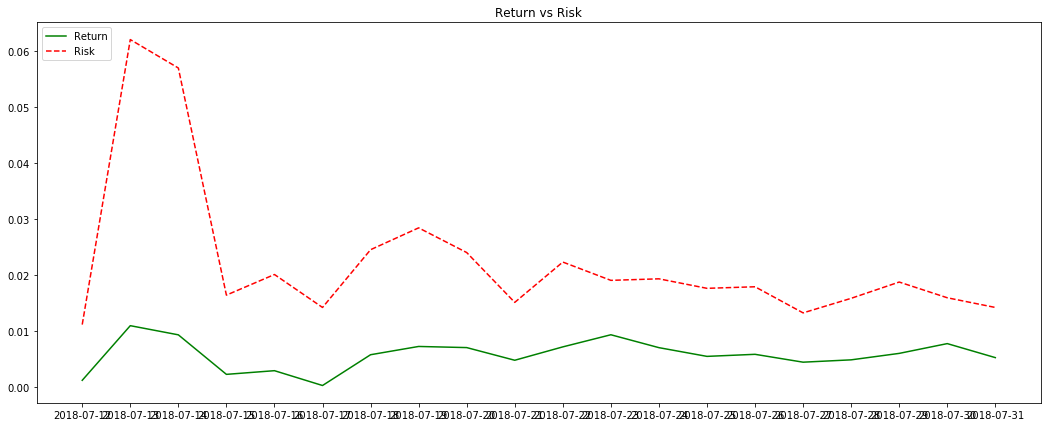

In [97]:
plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(stock_ts.index.values)) 
plt.plot(stock_ts['return'].values,label='Return',color='green')
plt.plot(stock_ts['risk'].values,'k--',label='Risk',color='red')
plt.title('Return vs Risk')
plt.legend(loc='upper left')
plt.show()

* *** Crypto optmization outcomes: Return vs Risk ***

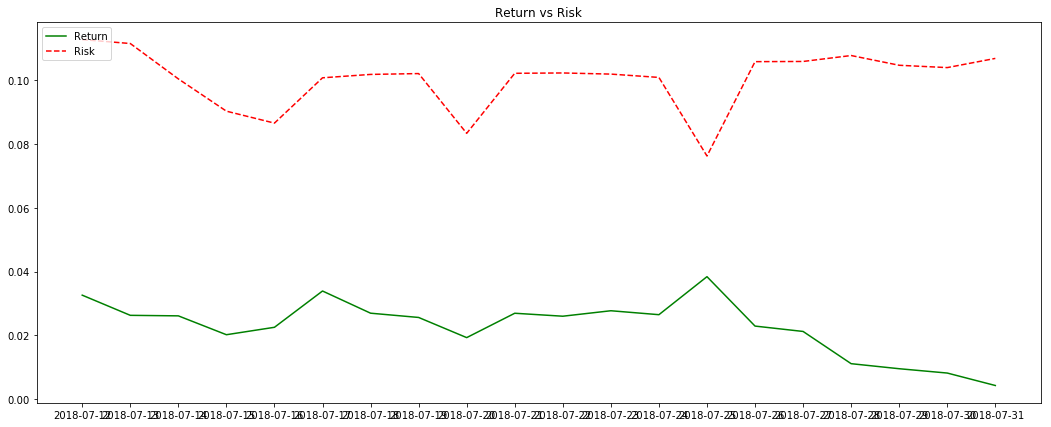

In [98]:
plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(ccur_ts.index.values)) 
plt.plot(ccur_ts['return'].values,label='Return',color='green')
plt.plot(ccur_ts['risk'].values,'k--',label='Risk',color='red')
plt.title('Return vs Risk')
plt.legend(loc='upper left')
plt.show()

* *** Mixed optmization outcomes: Return vs Risk ***

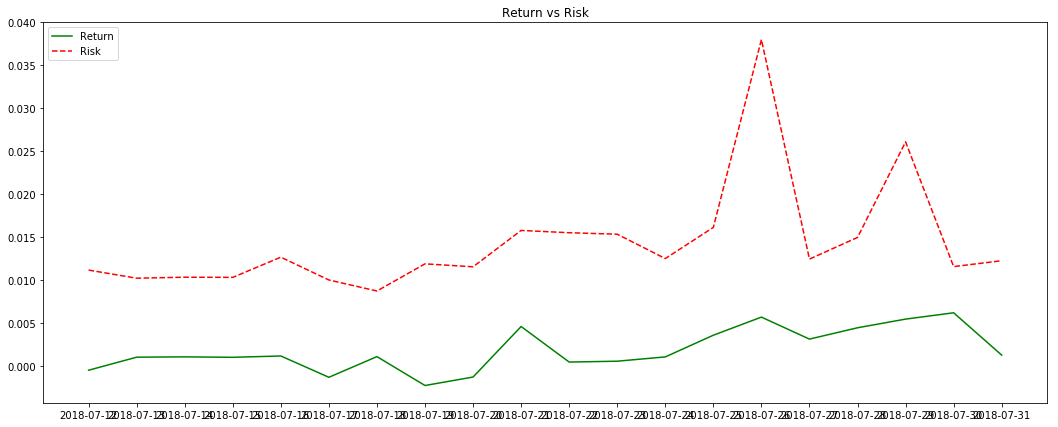

In [99]:
plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
plt.plot(mixed_ts['return'].values,label='Return',color='green')
plt.plot(mixed_ts['risk'].values,'k--',label='Risk',color='red')
plt.title('Return vs Risk')
plt.legend(loc='upper left')
plt.show()

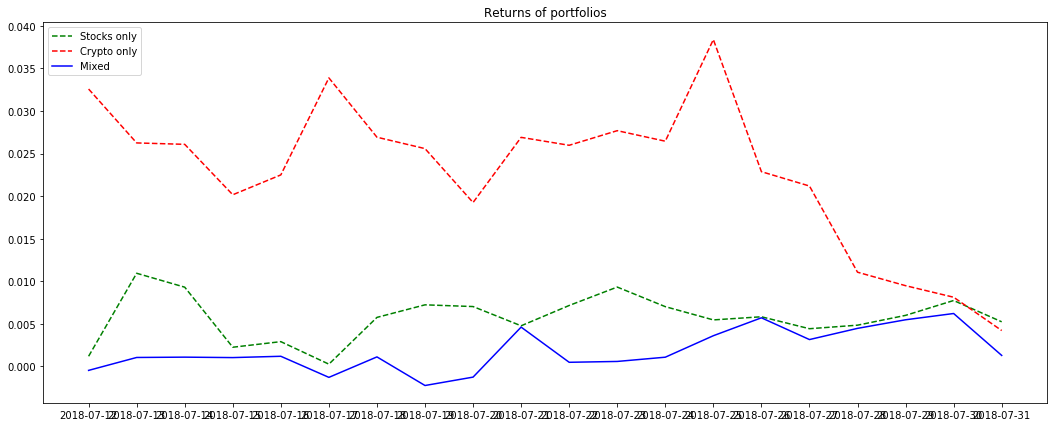

In [100]:
# All portfolios type return

plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
plt.plot(stock_ts['return'].values,'k--',label='Stocks only',color='green')
plt.plot(ccur_ts['return'].values,'k--',label='Crypto only',color='red')
plt.plot(mixed_ts['return'].values,label='Mixed',color='blue')
plt.title('Returns of portfolios')
plt.legend(loc='upper left')
plt.show()

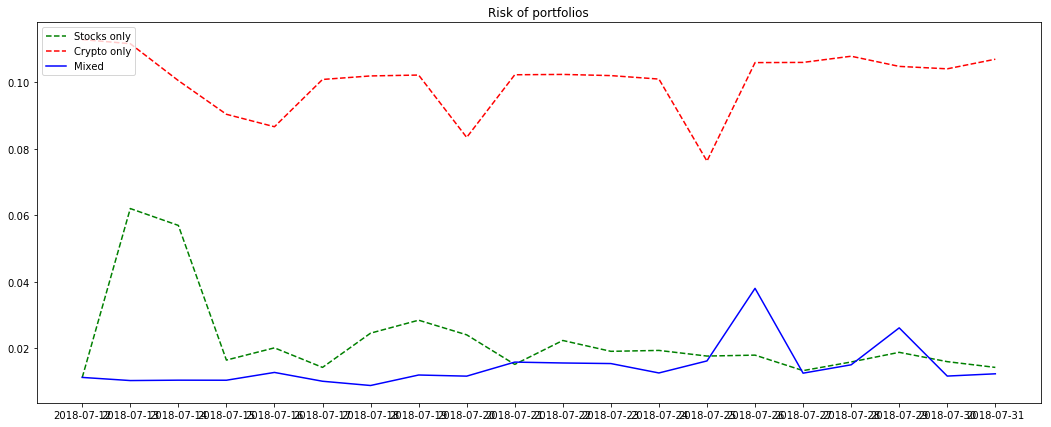

In [101]:
# All portfolios type Risk

plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
plt.plot(stock_ts['risk'].values,'k--',label='Stocks only',color='green')
plt.plot(ccur_ts['risk'].values,'k--',label='Crypto only',color='red')
plt.plot(mixed_ts['risk'].values,label='Mixed',color='blue')
plt.title('Risk of portfolios')
plt.legend(loc='upper left')
plt.show()

## Further outcome analysis

*** Temporal Aggregated Error and residual analysis ***

As the optimization takes place in specific days, the standard error of the estimate is defined as [David Longsteet]:

$$ Standard \ Error = \sqrt{\frac{\sum{{(\hat{Re} - Re)}^2}}{n-2}} $$




In [102]:
def get_errors(simulation_outcomes, returns_df, time_window = 30):
    substract_acum = 0
    predicted_returns, real_returns = list(), list()
    for date_index in simulation_outcomes.index:
        day = datetime.strptime(date_index, '%Y-%m-%d')
        # If the days checked are weekends, the friday before is considered instead
        test_date_index = date_index
        if day.weekday() == 5:
            test_date_index = (day + relativedelta(days = -1)).strftime('%Y-%m-%d')
        elif day.weekday() == 6:
            test_date_index = (day + relativedelta(days = -2)).strftime('%Y-%m-%d')

        # Holiday
        try:
            returns_df.loc[test_date_index]
        except:
            test_date_index = (datetime.strptime(test_date_index, '%Y-%m-%d') + relativedelta(days = -1)).strftime('%Y-%m-%d')
            
        real_return = returns_df.loc[test_date_index].dot(simulation_outcomes.loc[date_index]['weights'])
        predicted_return = simulation_outcomes.loc[date_index]['return']
        
        predicted_returns.append(predicted_return)
        real_returns.append(real_return)
        substract_acum += (np.subtract(predicted_return, real_return))**2
    
    std_error = np.sqrt(np.divide(substract_acum, time_window - 2))
    predicted_returns = pd.Series(predicted_returns)
    predicted_returns.index = simulation_outcomes.index
    real_returns = pd.Series(real_returns)
    real_returns.index = simulation_outcomes.index
    return std_error, predicted_returns, real_returns


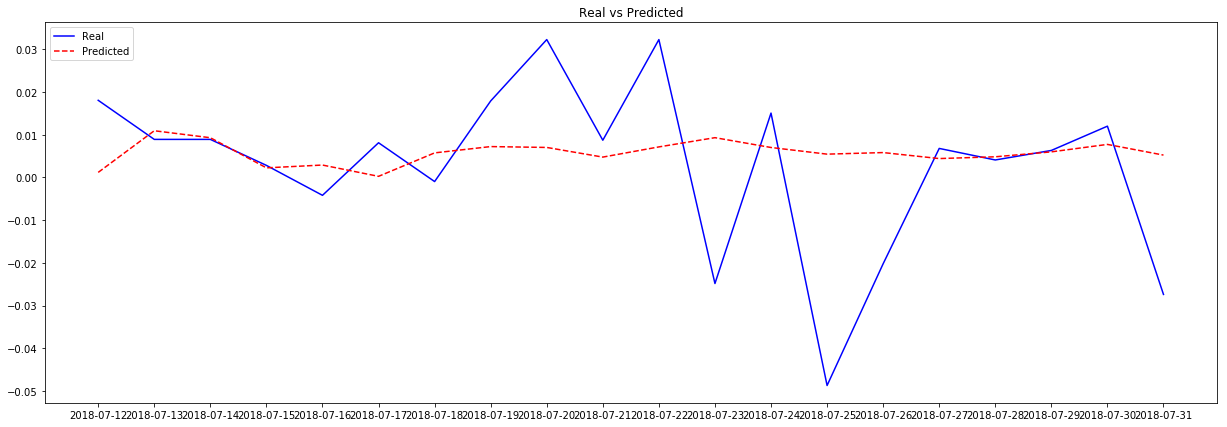

* Mean of predicted returns:  0.00573126958809
* Mean of real returns:  0.0028020764268
* Standard error of estimation:  0.0166697595216


In [103]:
# stocks
stock_std_error, stock_predicted_returns, stock_real_returns = get_errors(stock_ts, percent_stocks_returns, pre_fixed_time_window)

plt.figure(figsize=(21,7))
plt.xticks(range(num_iterations), list(stock_predicted_returns.index.values)) 
plt.plot(stock_real_returns.values,label='Real',color='blue')
plt.plot(stock_predicted_returns.values,'k--',label='Predicted',color='red')
plt.title('Real vs Predicted')
plt.legend(loc='upper left')
plt.show()

print('* Mean of predicted returns: ', stock_predicted_returns.mean())
print('* Mean of real returns: ', stock_real_returns.mean())
print('* Standard error of estimation: ', stock_std_error)

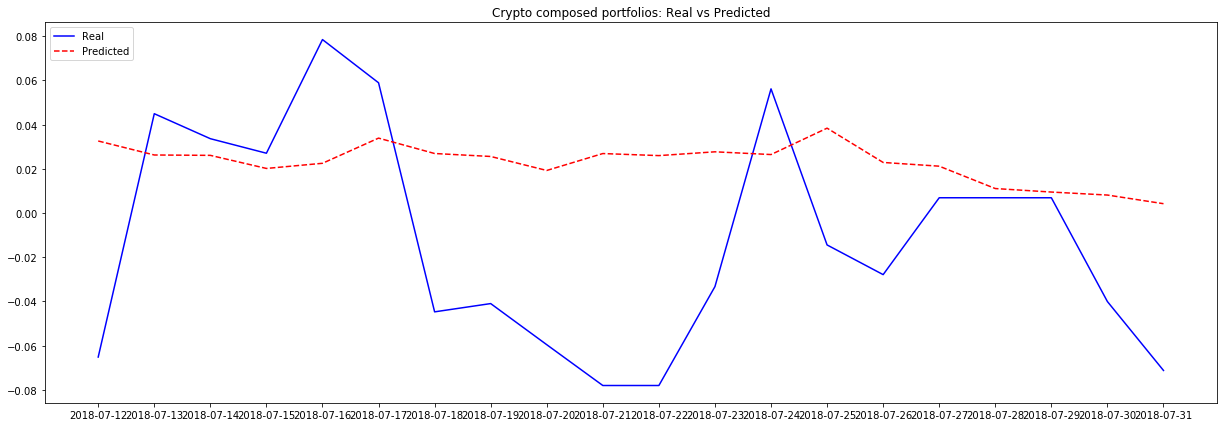

* Mean of predicted returns:  0.0227758761898
* Mean of real returns:  -0.0116861981973
* Standard error of estimation:  0.049860458321


In [104]:
# Crypto
crypto_std_error, ccurr_predicted_returns, ccurr_real_returns = get_errors(ccur_ts, percent_cripto_returns, pre_fixed_time_window)

plt.figure(figsize=(21,7))
plt.xticks(range(num_iterations), list(ccurr_predicted_returns.index.values)) 
plt.plot(ccurr_real_returns.values,label='Real',color='blue')
plt.plot(ccurr_predicted_returns.values,'k--',label='Predicted',color='red')
plt.title('Crypto composed portfolios: Real vs Predicted')
plt.legend(loc='upper left')
plt.show()

print('* Mean of predicted returns: ', ccurr_predicted_returns.mean())
print('* Mean of real returns: ', ccurr_real_returns.mean())
print('* Standard error of estimation: ', crypto_std_error)

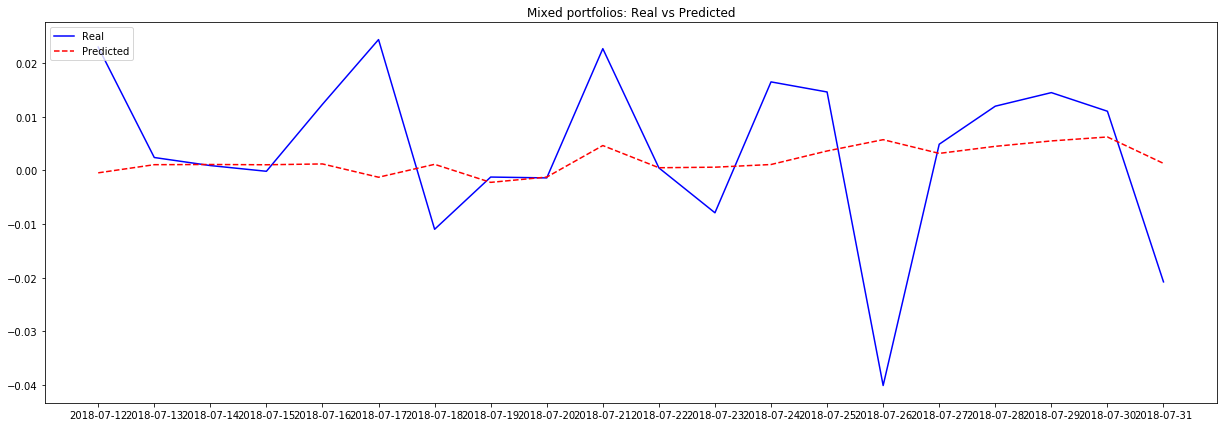

* Mean of predicted returns:  0.00184213867036
* Mean of real returns:  0.00383537219382
* Standard error of estimation:  0.0133408519801


In [105]:
# Mixed
mix_std_error, mix_predicted_returns, mix_real_returns = get_errors(mixed_ts, percent_returns_pd, pre_fixed_time_window)

plt.figure(figsize=(21,7))
plt.xticks(range(num_iterations), list(mix_predicted_returns.index.values)) 
plt.plot(mix_real_returns.values,label='Real',color='blue')
plt.plot(mix_predicted_returns.values,'k--',label='Predicted',color='red')
plt.title('Mixed portfolios: Real vs Predicted')
plt.legend(loc='upper left')
plt.show()

print('* Mean of predicted returns: ', mix_predicted_returns.mean())
print('* Mean of real returns: ', mix_real_returns.mean())
print('* Standard error of estimation: ', mix_std_error)

*** Summarized return in time: real vs predicted ***

Using the outcomes of the simulations, it is possible to measure the aggregated profit  

In [91]:
def get_aggregated_profit_in_percent(returns):  
    ammount = 100
    for rate in returns.values:
        ammount += np.multiply(ammount, rate)
    return np.subtract(ammount, 100)

In [92]:
# stocks comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(stock_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(stock_real_returns)
print('Real aggregated profit using only stocks: ',aggregated_profit_r_return, "%")
print('Predicted aggregated profit using only stocks: ',aggregated_profit_p_return, '%')

Real aggregated profit using only stocks:  0.55178668748 %
Predicted aggregated profit using only stocks:  4.73853974673 %


In [93]:
# Crypto comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(ccurr_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(ccurr_real_returns)
print('Real aggregated profit (in percent) using only crypto: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using only crypto: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using only crypto:  -5.21435946997 %
Predicted aggregated profit (in percent) using only crypto:  21.3650083699 %


In [94]:
# mixed comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(mix_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(mix_real_returns)
print('Real aggregated profit (in percent) using mixed assets: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using mixed asset: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using mixed assets:  -27.5128875472 %
Predicted aggregated profit (in percent) using mixed asset:  7.01141159128 %


*** Mixed assets portfolio distribution of the outcome ***

Once the optimal portoflio has been calculated in each time period where the model ran, it is also desired to explore further whether the composition of mixed protfolios presents any pattern or not. This aims towards giving a basic insight about the optimal distribution of a portfolio of such type by knowing the percent of the capital destinated to stocks and to the criptocurrencies.   

In [146]:
num_stock_asset = len(percent_stocks_returns.columns)
num_cripto_assets = len(percent_cripto_returns.columns)

mixed_ts['percent_in_stocks'] = [100*sum(portfolio[0:num_stock_asset]) for portfolio in mixed_ts['weights']]
mixed_ts['percent_in_cripto'] = [100*sum(portfolio[num_stock_asset:num_stock_asset+num_cripto_assets]) for portfolio in mixed_ts['weights']]

mixed_ts['lag_in_days'] = mixed_ts.index

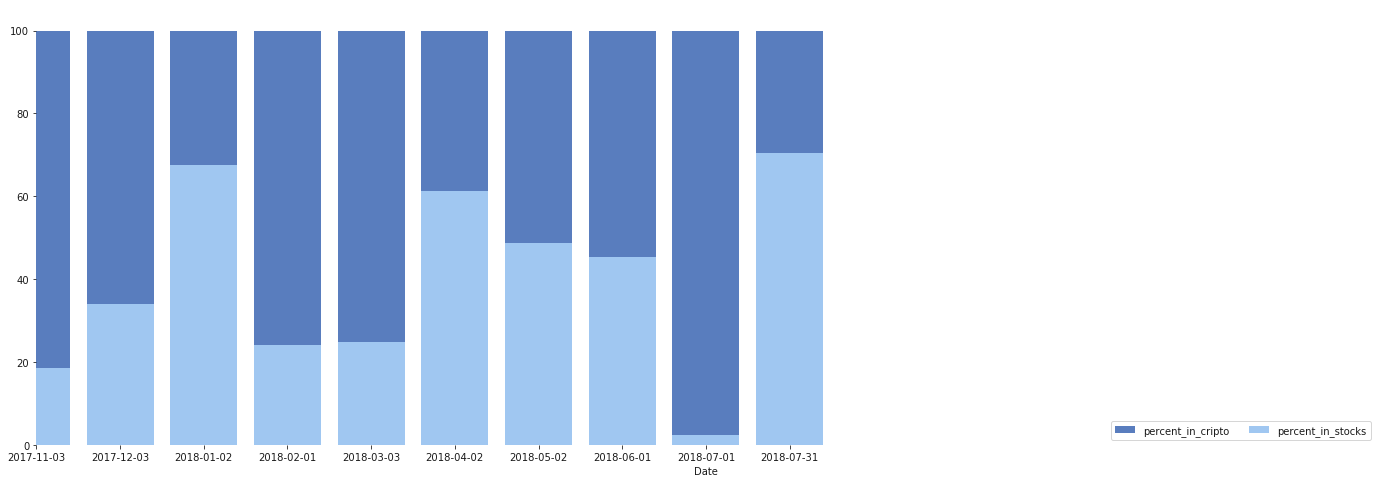

In [147]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(24, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 16), ylabel="",
       xlabel="Date")
sns.despine(left=True, bottom=True)

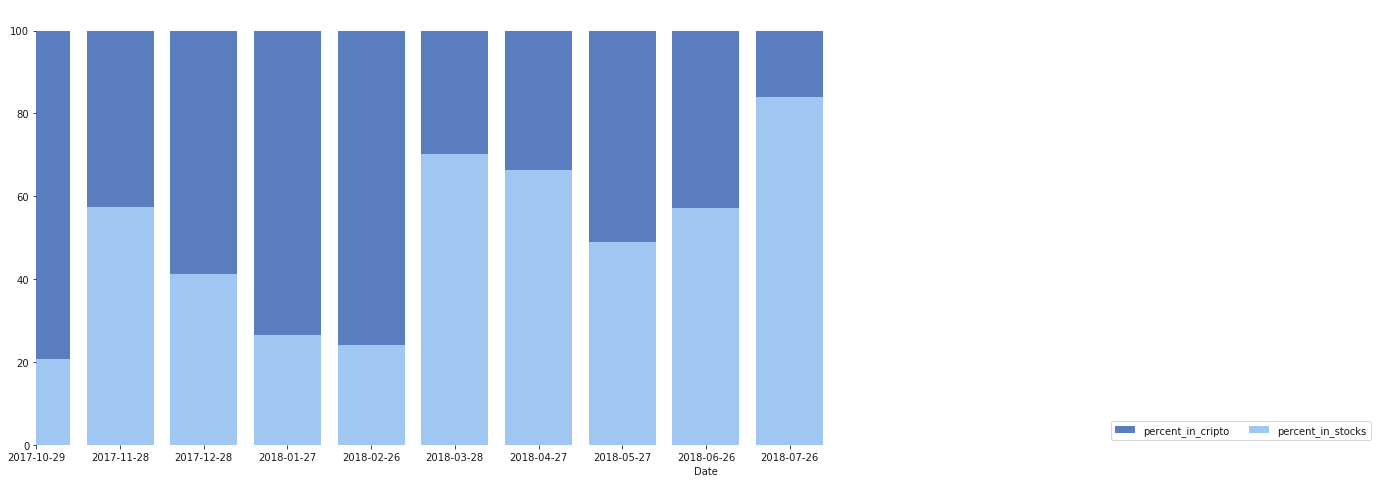

In [159]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(24, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 16), ylabel="",
       xlabel="Date")
sns.despine(left=True, bottom=True)

In [119]:
# Cleaning df
mixed_ts.drop(['temp_dim', 'lag_in_days'], axis = 1)

,return,risk,weights,portafolio_type,ratio_of_sharpe,percent_in_stocks,percent_in_cripto
2017-10-29,0.014109,0.072428,"[0.0, 0.206601082791, 0.0, 0.0, 0.0, 0.0, 0.0,...",mixed_assets,-0.388834,20.660108,79.339892
2017-11-28,0.012688,0.035447,"[0.117084679821, 0.105806764636, 0.0, 0.117084...",mixed_assets,-0.967861,57.414548,42.585452
2017-12-28,0.005428,0.035924,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37128664...",mixed_assets,-0.573023,41.340576,58.659424
2018-01-27,0.016053,0.047636,"[0.0, 0.0, 0.0, 0.0143221793986, 0.0, 0.245192...",mixed_assets,-0.437239,26.442362,73.557638
2018-02-26,0.046650,0.073712,"[0.0, 0.0876858915059, 0.0441539121685, 0.0, 0...",mixed_assets,-0.466182,24.201096,75.798904
2018-03-28,0.005721,0.033453,"[0.146304273815, 0.0, 0.148858309009, 0.0, 0.0...",mixed_assets,-0.826326,70.228338,29.771662
2018-04-27,0.002393,0.030975,"[0.221208011422, 0.221208011422, 0.0, 0.221208...",mixed_assets,-0.917063,66.362403,33.637597
2018-05-27,0.016430,0.046022,"[0.0, 0.0, 0.0, 0.0, 0.400033778758, 0.0, 0.0,...",mixed_assets,-0.468035,48.927573,51.072427
2018-06-26,-0.007762,0.019219,"[0.142857142857, 0.0, 0.0, 0.0, 0.142857142857...",mixed_assets,-0.909994,57.142857,42.857143
2018-07-26,0.006633,0.016167,"[0.0, 0.259378578447, 0.0, 0.253898422967, 0.0...",mixed_assets,-1.318795,83.912553,16.087447


# TO DO:

* Clean data, at least for criptocurrencies with few tracking history registers. [OK]
* Fix when a big amount of past data is considered when performing optmizations [OK]
* Select most valuable assets of Bovespa [OK - But considering the state in Marxh Only]
* Demonstrate variation between cotations in real and dolar - Not relevant because a differianted series is taken.
* Calculate the mixed portfolios distribution in 3 stages:
    * Ratio of sharpe
    * Max. return
    * Min. Risk
    
* Real error analysis (Mean - retorno real) for normal AVG - and AVG [OK]
* GARCH models, calculate the return of a single asset, this will minimize the error.
* Calculate the real return after calculating all optimized portfolios within the defined time interval.

# Improvements and future work

* Based on the work developed by Alberto Blanco Garcés (@alberduris github user), predicting either stocks and cryptocurrencies prices using RNN or recurrent neural networks, offer appareantly good results in the forecasts. Test this approach instead of GARCH. precision and time-complexity in execution also.